### Investigating exclusion criteria, Treasury rate features, best possible accuracy, and better comparisons of accuracy between models

Last modified by Gil on 11/10/2022.

This notebook investigates estimating yield spread, modified yield spread, YTW, and dollar price, each using LightGBM.
High-level notes:

3. We investigate different minimum sizes for the most recent trade.
4. Code has been rewritten to maximize speed (by avoiding row by row operations)
and to minimize memory usage (by avoiding copying dataframes).

Important remarks carried over from previous notebooks:

1. Accuracy is best for modified yield spread, called same_ys.
This is yield spread computed for the categorical calc date used for the most recent trade.
1. Accuracy for dollar price predictions is converted to accuracy for yield predictions
by scaling using DV01.
2. Experiments below lead to suggested minimal new exclusion criteria,
explained in https://docs.google.com/document/d/16e6TTMx0BVN5AC-3Zg2heFcabHZSiTFl6eWWCUjUzlg/edit.
3. Almost every available feature in the data file is used. 
The main exception is non-numerical features with more than a maximum number of distinct values.
These are text fields, and identifiers such as the cusip.
4. LightGBM models use the most recent trade, but not trade histories.

New findings:
1. Examining consecutive large trades suggests that the best achievable accuracy is around 6 basis points. (Should this be 3.3 basis points?)
2. Ratings from S&P and Moody's provide an unclear change in accuracy.
3. Treasury rate features do not appear among the 20 top in LightGBM importance plots.
4. The optimal minimum size for the last trade is 10,000 dollars (inclusive or not).
Larger minima mean that the last trade is less recent.
5. Changing the random seed can cause a difference in test accuracy of half a basis point.
This implies that the random seed is an important hyperparameter,
and that accuracy differences with different input features can only be reliable 
if they are larger than half a basis point.
6. The second most important feature is the combination of the last trade type and the target trade type.
This makes sense, because the yield given one trade direction must be adjusted 
to be a fair estimate of the yield given a different direction. 


Findings from earlier notebooks, confirmed here:
1. Predicting modified yield spread is more accurate than predicting regular yield spread.
We found earlier that predicting YTW or dollar price was sometimes best, 
but that is not true here, measured using DV01.
2. Given September 2022 as the test month, the best accuracy comes from using June, July, and August for training.
More months or fewer months lead to worse accuracy.
3. We can improve MAE by about 1.5 basis points by restricting predictions to the 90% of cases 
where a separate model predicts that the error of the main model expected to be smaller.

In [105]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
print("pandas version", pd.__version__)

import time
import datetime
from datetime import datetime
import re
import matplotlib.pyplot as plt
from matplotlib import colors

# from google.cloud import bigquery
# from google.cloud import storage
# import gcsfs

from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay

import lightgbm
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier

import os, gc, psutil

# from ficc.data.process_data import process_data
# from ficc.utils.gcp_storage_functions import upload_data, download_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pandas version 1.5.1


#### Comments on achieving efficient code

Pandas keeps track of different versions of the same dataframe in an effcient way,
using memory to store only changes. 
Dataframes should not be updated in-place, because then other dataframes that share the same memory are changed also,
which is undesired behavior.
Dataframes should also not be copied, because that increases memory usage dramatically,
and is slow.

Dataframes are stored with contiguous columns, not contiguous rows.
Therefore, "apply" for every row of a dataframe is intrinsically slow compared to operations on entire columns.
Where possible, avoid using "apply" at all.
Pandarallel is both slow and memory-intensive.

We want to make it easy to release memory used by variables, in particular dataframes. 
However, memory can be garbage-collected only if all names that refer to it are out of scope.
To do: Find a way to guarantee that all names referring to a given dataframe are out of scope.

Strategy to minimize memory consumption:
- Never use .copy()
- Minimize the number of new dataframe variables, since each one is an alias that may prevent garbage collection.

Strategy to maximize speed:
- Avoid ".apply()" and other operations that work one row at a time.
- Instead, use operations that work on entire columns of a dataframe.

In [106]:
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../eng-reactor-287421-112eb767e1b3.json" # for Charles
# os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'           # disable logging output from TensorFlow

pd.options.mode.chained_assignment = None            # disable warnings about too many changes to a dataframe
pd.options.display.precision = 3
pd.options.display.width = 160
pd.options.display.max_rows = 300
pd.options.display.min_rows = 15

#### Query to fetch data

This query is not used below, but is included as documentation.

In [107]:
# bq_client = bigquery.Client()
# storage_client = storage.Client()

DATA_QUERY = ''' 
SELECT
  * except(most_recent_event)
FROM
  `eng-reactor-287421.auxiliary_views.materialized_trade_history`
WHERE
  AND trade_date >= '2022-04-01'
  AND trade_date <= '2022-09-30'
  AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
ORDER BY
  trade_datetime desc
''' 

#### Loading data from a local pickle file

We transfer the data from a GCP bucket to a local file, and load that into pandas.
Depending on garbage collection, loading the data may sometimes seem to use negative memory.

Most exclusions have been eliminated, but some exclusions from the SQL pipeline remain. 
These exclusions include trades less than \$10,000, and the price delta exclusion. 
It is possible that additional exclusions remain also.
For info on previous exclusions, see https://docs.google.com/document/d/1PS4Eew9bf78Mb0vRzL5Lk3WW-kq_-jiFqnY5c1YFMoQ/edit.

- The October 18 file excludes trades with <= 400 days to maturity.

This lets us try different ideas in feature engineering and model design far quicker.
Just as important, it makes downstream work more pleasant and 
makes us much more motivated to find and fix errors. 
Fast data processing is absolutely crucial, in particular, when a bug causes the Python kernel to crash,
and all previous computation in the notebook is lost.

In [108]:
name = "/Users/gil/git/ficc/notebooks/gil_modeling/processed_data_2022-10-21-17:41-flags-corporate-spreads.pkl"

gc.collect()
before = psutil.Process().memory_info().rss

%time with open(f"{name}", 'rb') as f: data = pd.read_pickle(f)

after = psutil.Process().memory_info().rss
diff = after - before
print(f"Loaded {name} using {diff/1e9:.3f} gigabytes in {after/1e9:.3f} total gigabytes")

CPU times: user 32.3 s, sys: 32.4 s, total: 1min 4s
Wall time: 1min 10s
Loaded /Users/gil/git/ficc/notebooks/gil_modeling/processed_data_2022-10-21-17:41-flags-corporate-spreads.pkl using 7.515 gigabytes in 15.411 total gigabytes


We create the yield-to-worst label, check that it is correct,
and save the data to enable fast re-initialization later.

In [5]:
#uss -  a function that monitors memory usage. he output is how many gigabytes of memory are being used. Pageins happen when there is not enough physical memory.

prevpageins = 0
def uss():
    global prevpageins
    gc.collect()
    info = psutil.Process().memory_full_info()
    newpageins = info.pageins
    diff = newpageins - prevpageins
    if diff > 0:
        print(f"Warning: {diff} new pageins")
        prevpageins = newpageins
    uss = info.uss / 1e9
    return uss

In [6]:
%%time
for col in ['par_traded', 'quantity', 'last_size', 'last_seconds_ago']:
    data[col] = data[col].astype('float64')
    avg = np.mean(data[col])
    print(col, avg)
    if avg > 10:
        data[col] = np.log10( data[col] + 1 )
if not 'ytw' in data.columns:
    data['ytw'] = data['yield'] * 100
    print( "MSE =", ((data.ytw - data.yield_spread - data.ficc_ycl)**2).mean() )
#uss()

par_traded 182049.73590208733
quantity 4.613252337547713
last_size 171584.05663397053
last_seconds_ago 2061279.4453163967
MSE = 6.093549197831675e-30
CPU times: user 6.18 s, sys: 8.02 s, total: 14.2 s
Wall time: 16.9 s


In [7]:
if not 'ytw' in data.columns: 
    data['ytw'] = data['yield'] * 100
    print( "MSE =", ((data.ytw - data.yield_spread - data.ficc_ycl)**2).mean() )
    
if not 'saved' in locals():
    saved = data

#### Limit to a subset of bonds

To do: Find out with certainty whether doing garbage collection after deleting all aliases for the data is successful in reclaiming memory.
If some aliases are not deleted, then garbage collection cannot succeed.

In [8]:
aliases = ['data', 'd', 'e', 'gby', 'prepped', 'tmid', 'test_dataframe', 'train_dataframe']
for name in aliases:
    if name in locals().keys(): del(name)
%time gc.collect();

CPU times: user 86.9 ms, sys: 106 ms, total: 193 ms
Wall time: 194 ms


0

Limiting to a smaller state such as New Jersey is useful for debugging.
Limiting to Texas or California is useful to obtain accuracy results faster.

In [9]:
%time data = saved # [saved.incorporated_state_code == "CA"].copy()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


#### Creating the trade type combination feature

Converting categories to strings is the simplest way to create a cross-product of discrete features.

In [10]:
data[data.pac_bond_indicator == True]

,MSRB_maturity_date,MSRB_coupon_rate,msrb_cusip,yield_spread,calc_price,price_to_next_call,price_to_par_call,price_to_maturity,calc_date,price_delta,...,last_ficc_ycl_to_next_call,last_ficc_ycl_to_par_call,last_ficc_ycl_to_refund,is_replica,is_bookkeeping,is_same_day,ntbc_precursor,corporate_yield,corporate_spread,ytw
9286,2052-12-01,5.500000000,13063DZ43,78.881,108.745,108.745,108.745,119.647,2031-12-01,1.000e-03,...,3.534,3.534,NaN,False,False,True,False,5.17,-163.281,432.6
9399,2052-12-01,5.500000000,13063DZ43,82.781,108.440,108.440,108.440,118.906,2031-12-01,0.000e+00,...,3.534,3.534,NaN,False,False,True,False,5.17,-163.281,436.5
9940,2049-07-01,4.500000000,880461XF0,118.092,100.399,100.399,100.399,101.366,2028-01-01,1.000e-03,...,3.316,3.316,NaN,False,False,False,False,4.70,-146.892,441.2
15035,2052-12-01,5.500000000,13063DZ43,82.081,108.494,108.494,108.494,119.038,2031-12-01,2.000e-03,...,3.534,3.534,NaN,False,False,True,False,5.17,-163.281,435.8
15145,2052-12-01,5.500000000,13063DZ43,82.081,108.494,108.494,108.494,119.038,2031-12-01,2.000e-03,...,3.496,3.496,NaN,False,False,False,True,5.17,-163.281,435.8
15146,2052-12-01,5.500000000,13063DZ43,82.881,108.432,108.432,108.432,118.887,2031-12-01,4.000e-03,...,3.496,3.496,NaN,False,False,True,False,5.17,-163.281,436.6
18775,2049-01-01,4.000000000,6472007V0,61.608,100.366,101.253,100.366,101.052,2029-04-01,1.000e-03,...,3.200,3.318,NaN,False,False,False,False,4.85,-153.108,393.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5273694,2049-04-01,3.500000000,70879QGL1,97.361,102.173,102.173,102.173,106.312,2029-04-01,2.000e-03,...,2.177,2.177,NaN,False,False,False,False,3.14,-96.261,315.1
5273733,2049-04-01,3.500000000,70879QGL1,105.261,101.676,101.676,101.676,104.838,2029-04-01,1.000e-03,...,2.177,2.177,NaN,False,False,False,False,3.14,-96.261,323.0


In [11]:
data['ttypes'] = (data.last_trade_type.astype(str) + data.trade_type.astype(str)).astype('category')
data.ttypes.value_counts()

DD       877357
SD       695764
DS       691440
SP       634547
SS       605216
PS       581912
PD       493873
DP       441961
PP       248989
NoneS         5
Name: ttypes, dtype: int64

Check which months are in the data and how the rows are sorted.

In [12]:
month = data.trade_date.dt.month
print( month.value_counts() )

data.loc[:,'trade_datetime']

5     911428
6     855779
4     828324
9     819763
8     708552
7     699100
10    448118
Name: trade_date, dtype: int64


0         2022-10-14 17:54:00
1         2022-10-14 17:52:29
2         2022-10-14 17:52:00
3         2022-10-14 17:48:14
4         2022-10-14 17:48:14
5         2022-10-14 17:36:18
6         2022-10-14 17:36:18
                  ...        
5296711   2022-04-01 07:07:00
5296712   2022-04-01 07:05:40
5296713   2022-04-01 07:05:00
5296714   2022-04-01 07:04:02
5296715   2022-04-01 07:04:00
5296716   2022-04-01 07:03:45
5296717   2022-04-01 07:03:00
Name: trade_datetime, Length: 5271064, dtype: datetime64[ns]

The data file from September 12 has many fewer columns than earlier files.
This is fixed in the September 27 file and later. However, that file leads to worse accuracy,
despite similar preprocessing in this notebook.
To do: Investigate why.

In [13]:
%time data.info(verbose=True, show_counts=True) # , memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5271064 entries, 0 to 5296717
Data columns (total 286 columns):
 #    Column                                   Non-Null Count    Dtype              
---   ------                                   --------------    -----              
 0    MSRB_maturity_date                       5271064 non-null  datetime64[ns]     
 1    MSRB_coupon_rate                         5271064 non-null  object             
 2    msrb_cusip                               5271064 non-null  object             
 3    yield_spread                             5271064 non-null  float64            
 4    calc_price                               5271064 non-null  float64            
 5    price_to_next_call                       5271064 non-null  float64            
 6    price_to_par_call                        5271064 non-null  float64            
 7    price_to_maturity                        5271064 non-null  float64            
 8    calc_date                     

#### Investigating days to refund

In the October 18 data, trades with refund date less than 399 days in the future have been excluded.
Many bonds have been called, but still have  refund dates far in the future.
To do: Understand why.

CPU times: user 889 ms, sys: 690 ms, total: 1.58 s
Wall time: 1.59 s
1


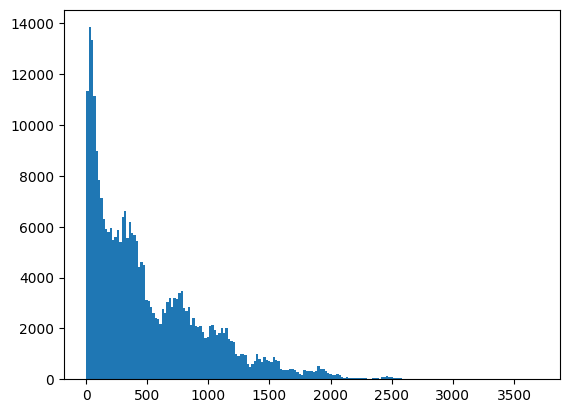

In [14]:
%time d = data[(data.days_to_refund > 0) & data.is_called]
e = (d.refund_date - d.settlement_date).dt.days
print(e.min())
plt.hist(e, bins="auto");

In [15]:
#data[(data.refund_date - data.settlement_date).dt.days > 2000].to_csv("myles.csv")

#### Exclusions

We exclude bonds with rare feature values that are correlated with (and likely causal for) low accuracy.
We also exclude bonds that will be repaid in less than 400 days.
For these bonds, estimating yield is less relevant than estimating dollar price, and YTW can be unreasonably high.
For more discussion, see https://docs.google.com/document/d/16e6TTMx0BVN5AC-3Zg2heFcabHZSiTFl6eWWCUjUzlg/edit.
Note that exclusion based on calc_date or YTW would constitute leakage.

In [16]:
len(data)

5271064

In [17]:
%%time
def remove(tmid, predicate, message="", negate=False):
    exclude = predicate(tmid)
    if negate: exclude = ~exclude
    if message != "":
        print(f"removing {message:40} {100*(exclude.mean()):6.4f}% {exclude.sum():10}")
    retain = ~exclude
    return tmid[retain]

def remcolval(tmid, col, val):
    if not col in tmid.columns:
        print("absent column", col)
        return tmid
    else:
        predicate = (lambda df: df[col] == val)
        return remove(tmid, predicate, f"{col}={val}")

def inside(x, a, b):
    return (x > a) & (x < b)

data = remcolval(data, "default_indicator", True)
data = remcolval(data, "sp_watch_long", "WATCH NEG")
data = remcolval(data, "sec_regulation", 2.0)
data = remcolval(data, "pac_bond_indicator", True)
data = remcolval(data, "called_redemption_type", 3.0)
data = remcolval(data, "sp_outlook_long", "DEVELOPING")
data = remcolval(data, "coupon_type", 10)
data = remcolval(data, "coupon_type", 23)
data = remcolval(data, "sink_fund_redemption_method", 5.0)
data = remcolval(data, "maturity_description_code", 26.0)

data = remove(data, (lambda df: inside(df.days_to_maturity, 0, np.log10(400)) ), "days_to_maturity < 400")
data = remove(data, (lambda df: inside(df.days_to_refund, 0, np.log10(400)) ),   "days_to_refund < 400  ")

removing default_indicator=True                   0.0945%       4981
removing sp_watch_long=WATCH NEG                  0.0721%       3795
removing sec_regulation=2.0                       0.0512%       2695
removing pac_bond_indicator=True                  0.0333%       1754
removing called_redemption_type=3.0               0.3289%      17293
removing sp_outlook_long=DEVELOPING               0.0227%       1189
removing coupon_type=10                           0.0607%       3179
removing coupon_type=23                           0.0001%          3
removing sink_fund_redemption_method=5.0          0.0070%        365
removing maturity_description_code=26.0           0.0235%       1232
removing days_to_maturity < 400                   6.6804%     349690
removing days_to_refund < 400                     2.7793%     135767
CPU times: user 1min 16s, sys: 57.9 s, total: 2min 14s
Wall time: 2min 26s


In [18]:
len(data)

4749121

#### Removing useless fields

Some fields that should be uninformative have strange patterns. To do: Investigate these further.

- _id_ has strange correlations with trade date.
- _id_ and _num_ are mostly but not exactly the same.
- rtrs_control_number is the date concatenated with a sequence number that starts again each day.
- call_date_notice is always the year 1970, but with some microseconds of variation.
- seq_num counts up each day.
- The fields d and q contain almost exactly the same information. In any case, they are obsolete.

In general, we want to be cautious about removing fields that might have some predictive power, even if small.
However, it is difficult to measure small increases in predictive power,
because of randomness in training models.

To do: Make code that computes mutual information fast.

In [19]:
# from https://stackoverflow.com/questions/35850582/can-pandas-dataframe-efficiently-calculate-pmi-pointwise-mutual-information
def pmi(dff, x, y):
    df = dff
    df['f_x'] = df.groupby(x)[x].transform('count')
    df['f_y'] = df.groupby(y)[y].transform('count')
    df['f_xy'] = df.groupby([x, y])[x].transform('count')
    df['pmi'] = np.log(len(df.index) * df['f_xy'] / (df['f_x'] * df['f_y']) )
    return df

# pmi(data,'q','d')

We delete the fields mentioned above, plus some others.

In [20]:
droplist = ['id', 'num', 'seq_num', 'sequence_number', 'rtrs_control_number', 'q', 'd']
droplist = droplist + ['coupon', 'issue_key_copy', 'A/E', 'scaled_accrued_days']
droplist = droplist + ['target_attention_features', 'call_date_notice', 'call_cav']

%time data = data.drop(droplist, axis=1, errors='ignore')

CPU times: user 4.53 s, sys: 2.61 s, total: 7.14 s
Wall time: 7.16 s


The values of calc_day_cat are 0, next_call_date; 1, par_call_date; 2, maturity_date; or 3, refund_date.
Any value other than 0, 1, 2, 3, or missing, is an error and should be fixed upstream.
If calc_day_cat and last_calc_day_cat have very different distributions,
that is likely because trades close to redemption have been excluded upstream in the data file.

To do: Investigate the correctness of the transition matrix from last_calc_day_cat to calc_day_cat.

In [21]:
pd.crosstab( data.last_calc_day_cat, data.calc_day_cat, dropna=False )

calc_day_cat,0,1,2,3
last_calc_day_cat,,,,
0.0,1913247,477,184138,2053
1.0,178,2985,1255,2
2.0,92018,558,2418425,108
3.0,4,0,11,133657


To do: Find out why zerocoupon and has_zero_coupons are not identical.

In [22]:
pd.crosstab( data.zerocoupon, data.has_zero_coupons, dropna=False )

has_zero_coupons,False,True
zerocoupon,,
False,4685484,0
True,0,63637


#### Creating labels that are easier to predict

Units are basis points.
- same_ys is the yield spread for the current trade relative to last_calc_day_cat 
- ytw is the actual YTW for the current trade (i.e., the target trade)
- last_ytw is the actual YTW for the most recent previous trade
- adj_ytw is a better predictor of YTW.

Hypotheses:
- same_ys is a better target than yield_spread; correlation of last_yield_spread is higher with same_ys than with yield_spread
- last_ytw is a good predictor for ytw; correlation of ytw is high with last_ytw, but even higher with adj_ytw.

Note that ycl_diff is not a leaker, because it is based on last_calc_day_cat.
Also note that if last_calc_day_cat etc. are changed, for example because different previous trades are ignored,
then _mkyields_ must be executed again.

In [23]:
def vestig(label, df, doprint = False):
    global dodebug
    if dodebug or doprint: 
        print(f"{label} \t {df.last_size.mean():6.3f} {df.last_seconds_ago.mean():6.3f}")

def investig(label):
    global data
    vestig(label,data)

def mkyields(df):
    investig("entering mkyields")

    lys = df.last_yield_spread
    last_ytw = 0 * lys
    same_ys = 0 * lys
    ycl_diff = 0 * lys

    sub = df.last_calc_day_cat == 0
    last_ytw[sub] = lys[sub] + df[sub].last_ficc_ycl_to_next_call * 100
    same_ys[sub] =  df[sub].ytw - df[sub].ficc_ycl_to_next_call * 100
    ycl_diff[sub] = (df[sub].ficc_ycl_to_next_call - df[sub].last_ficc_ycl_to_next_call) * 100

    sub = df.last_calc_day_cat == 1
    last_ytw[sub] = lys[sub] + df[sub].last_ficc_ycl_to_par_call * 100
    same_ys[sub] =  df[sub].ytw - df[sub].ficc_ycl_to_par_call * 100
    ycl_diff[sub] = (df[sub].ficc_ycl_to_par_call - df[sub].last_ficc_ycl_to_par_call) * 100

    sub = df.last_calc_day_cat == 2
    last_ytw[sub] = lys[sub] + df[sub].last_ficc_ycl_to_maturity * 100
    same_ys[sub] =  df[sub].ytw - df[sub].ficc_ycl_to_maturity * 100
    ycl_diff[sub] = (df[sub].ficc_ycl_to_maturity - df[sub].last_ficc_ycl_to_maturity) * 100

    sub = data.last_calc_day_cat == 3
    last_ytw[sub] = lys[sub] + df[sub].last_ficc_ycl_to_refund * 100
    same_ys[sub] =  df[sub].ytw - df[sub].ficc_ycl_to_refund * 100
    ycl_diff[sub] = (df[sub].ficc_ycl_to_refund - df[sub].last_ficc_ycl_to_refund) * 100

    df['same_ys'] = same_ys
    df['last_ytw'] = last_ytw
    df['ycl_diff'] = ycl_diff
    df['adj_ytw'] = last_ytw + ycl_diff
    investig("exiting mkyields")
    return df

def mkttypes(df):
    df['ttypes'] = (df.last_trade_type.astype(str) + df.trade_type.astype(str)).astype('category')
    return df

def mycorr(df,a,b):
    return df[[a,b]].corr().iloc[1,0]

def showcorrs(df):
    print("Correlations etc.")
    print( f"     last ys & ys: {mycorr(df,'last_yield_spread','yield_spread'):5.3f} \t  last ys avg: {df.last_yield_spread.mean():6.2f}" )
    print( f"last ys & same ys: {mycorr(df,'last_yield_spread','same_ys'):5.3f} \t  same ys avg: {df.same_ys.mean():6.2f}" )
    print( f"   last ytw & ytw: {mycorr(df,'last_ytw','ytw'):5.3f} \t last ytw avg: {df.last_ytw.mean():6.2f}" )
    print( f"    adj ytw & ytw: {mycorr(df,'adj_ytw','ytw'):5.3f} \t ycl diff std: {df.ycl_diff.std():6.2f}" )

In [24]:
dodebug = False
%time data = mkyields(data)
showcorrs(data)

CPU times: user 31.5 s, sys: 11.9 s, total: 43.4 s
Wall time: 43.5 s
Correlations etc.
     last ys & ys: 0.832 	  last ys avg:  52.60
last ys & same ys: 0.866 	  same ys avg:  51.99
   last ytw & ytw: 0.800 	 last ytw avg: 311.20
    adj ytw & ytw: 0.938 	 ycl diff std:  45.14


#### Using only large previous trades

Hypothesis: If the most recent previous traded is small, such as below 100,000 dollars,
then it is more predictive to use a larger but older trade instead.

Whenever the quantity of the last trade is less than a threshold, measured in log_10 dollars,
_mklarge_ replaces the last trade by the most recent earlier trade above the threshold in the same cusip.
The function _mkyields_ must be called after these replacements,
in order to update last_ytw and other derived feature values.

Note that _mklarge_ is much faster when _holes_ is restricted to only the necessary columns.
For some reason this restriction is also needed for "fillna(d)" to be successful.

In [25]:
def mklarge(d, threshold):
    investig("entering mklarge")
    
    d = d.copy()    # this prevents changes to "data" that are visible globally, but doesn't actually duplicate it
    
    lastcols = d.columns[d.columns.str.startswith('last_')].tolist()[1:]
    holes = d[lastcols + ['cusip'] ]
    # holes = d     # this is slower and causes fillna(d) to be a no-op

    holes.loc[d.last_size < threshold, lastcols] = np.nan
    # holes[lastcols][d.last_size < threshold] = np.nan   # this does not change entries in "holes"
    vestig("holes with lastcols only after = nan", holes)

    gbf = holes.groupby('cusip').bfill()
    vestig("holes after bfill", holes)

    holes = holes.fillna(gbf)
    vestig("holes after fillna(gbf)", holes)
    
    holes = holes.fillna(d)
    vestig("holes after fillna(d)", holes)

    d[lastcols] = holes[lastcols]
    
    vestig("holes after d = holes", holes)
    vestig("d after d = holes", d)
    investig("data after d = holes")
    
    diff = (d.trade_datetime - d.last_trade_datetime).dt
    d['last_seconds_ago'] = np.log10( 86400*diff.days + diff.seconds + 1 )
    
    d = mkyields(d)
    d = mkttypes(d)
    vestig("d after mkyields", d)
    investig("exiting mklarge")
    return d

In [26]:
%time e = mklarge(data, 4)
vestig("final e", e)
showcorrs(e)

CPU times: user 1min 24s, sys: 59.4 s, total: 2min 24s
Wall time: 2min 30s
Correlations etc.
     last ys & ys: 0.832 	  last ys avg:  52.60
last ys & same ys: 0.866 	  same ys avg:  51.99
   last ytw & ytw: 0.800 	 last ytw avg: 311.20
    adj ytw & ytw: 0.938 	 ycl diff std:  45.14


In [27]:
%time e = mklarge(data, 4.01)
vestig("final e", e)
showcorrs(e)

CPU times: user 1min 28s, sys: 1min 17s, total: 2min 45s
Wall time: 2min 54s
Correlations etc.
     last ys & ys: 0.826 	  last ys avg:  51.78
last ys & same ys: 0.863 	  same ys avg:  52.24
   last ytw & ytw: 0.783 	 last ytw avg: 307.77
    adj ytw & ytw: 0.936 	 ycl diff std:  48.35


In [28]:
%time e = mklarge(data, 4.1)
vestig("final e", e)
showcorrs(e)

CPU times: user 1min 28s, sys: 1min 19s, total: 2min 47s
Wall time: 2min 56s
Correlations etc.
     last ys & ys: 0.826 	  last ys avg:  51.78
last ys & same ys: 0.863 	  same ys avg:  52.25
   last ytw & ytw: 0.783 	 last ytw avg: 307.76
    adj ytw & ytw: 0.936 	 ycl diff std:  48.35


In [29]:
%time e = mklarge(data, 4.3)
vestig("final e", e)
showcorrs(e)

CPU times: user 1min 28s, sys: 1min 20s, total: 2min 48s
Wall time: 2min 56s
Correlations etc.
     last ys & ys: 0.823 	  last ys avg:  51.29
last ys & same ys: 0.861 	  same ys avg:  52.37
   last ytw & ytw: 0.775 	 last ytw avg: 305.92
    adj ytw & ytw: 0.936 	 ycl diff std:  49.91


In [30]:
%time e = mklarge(data, 4.7)
vestig("final e", e)
showcorrs(e)

CPU times: user 1min 28s, sys: 1min 20s, total: 2min 49s
Wall time: 2min 56s
Correlations etc.
     last ys & ys: 0.808 	  last ys avg:  51.58
last ys & same ys: 0.853 	  same ys avg:  52.22
   last ytw & ytw: 0.748 	 last ytw avg: 302.60
    adj ytw & ytw: 0.933 	 ycl diff std:  54.29


Conclusion: The threshold for the size of the last trade that maximizes correlations is 4.0 or 4.01, meaning that maybe we should not use 10,000 dollar trades,
but we should use all larger ones.

In [31]:
# %time data = mklarge(data, 4.01)

#### Estimating the best possible achievable accuracy

Idea: Find large trades where there was a previous large trade in the same cusip, on the same day,
in the same direction, between min and max seconds ago.
The difference in price or yield between these trades is presumably due to randomness that we could not predict.

Results are similar whether or not we use _mklarge_ to bring in large previous trades that were not the most recent.
MAE is reduced only slightly by making differences unbiased, i.e., shifting them to have mean zero.

In [32]:
large = np.log10(5e5)
toolarge = np.log10(5e6)

minseconds = np.log10(900)
maxseconds = np.log10(7200)

bayes = data
bayes = mklarge(bayes, large)     # optional, to look back beyond previous trades that are small

b = (bayes.last_size >= large) & (bayes.last_size < toolarge)
c = (bayes.quantity >= large) & (bayes.quantity < toolarge)
d = (bayes.last_seconds_ago >= minseconds) & (bayes.last_seconds_ago <= maxseconds)
e = (bayes.last_trade_type == bayes.trade_type)
f = (bayes.last_ytw != bayes.ytw)

combo = b & c & d & e # & f
print( b.mean(), c.mean(), d.mean(), e.mean(), f.mean(), combo.mean() )

bayes = bayes[combo]
print( len(bayes) )

diff = bayes.ytw - bayes.last_ytw
# diff = bayes.dollar_price - bayes.last_dollar_price
skew = diff.mean()

delta = (diff).abs()
print( skew, delta.mean(), delta.max() )

0.33894398563439426 0.03753010293904914 0.09010488467234253 0.3085116172024255 0.9998970335773715 0.0009740749919827269
4626
-0.21195628876277445 3.139485837638297 289.5120071032414


The mean absolute difference between a large trade and its large predecessor is around 3 basis points in yield or 16 cents in price.
Large trades close in time are the best case for predictability,
so these numbers are estimates of the best achievable accuracy.

The largest change in YTW between nearby large trades in the same cusip was around 290 bps in 748508A24 on May 6.
To do: Investigate these two trades.
<!-- This was for a bond with 4% coupon expected to be called on August 15,
so the price difference was not huge, exactly 50 cents.
Plausibly, 50 cents was a standard markup for the dealer. -->

In [33]:
cols = ['cusip', 'trade_date', 'dollar_price', 'last_dollar_price', 'ytw', 'last_ytw', 'calc_date', 'last_calc_date', 'trade_type', 'last_trade_type']
cols = cols + ['last_size', 'quantity']

upper = np.floor(delta.max())
print( bayes[cols][ delta >= upper ] )
# bayes[ delta > upper ].T

             cusip trade_date  dollar_price  last_dollar_price    ytw  last_ytw  calc_date last_calc_date trade_type last_trade_type  last_size  quantity
4285692  748508A24 2022-05-06        90.721            103.048  374.6    85.088 2026-12-15     2026-12-15          P               P      5.908     5.908


The values of calc_day_cat are 0, next_call_date; 1, par_call_date; 2, maturity_date; or 3, refund_date.
To do: Understand the following plots.

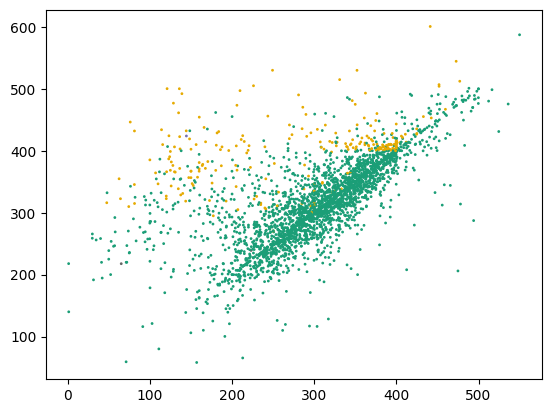

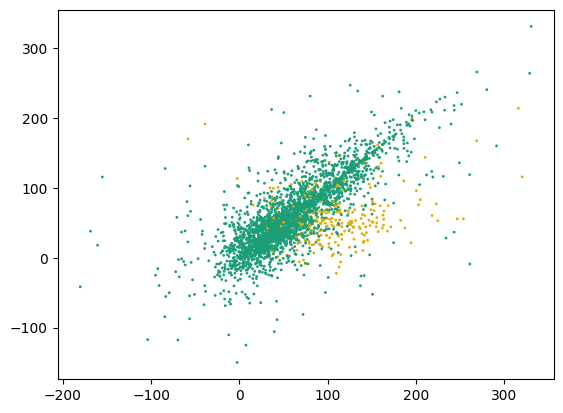

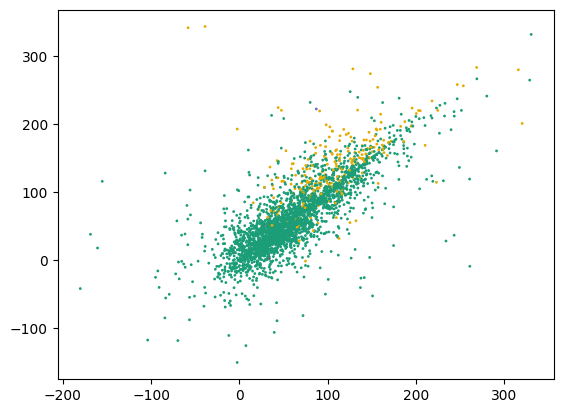

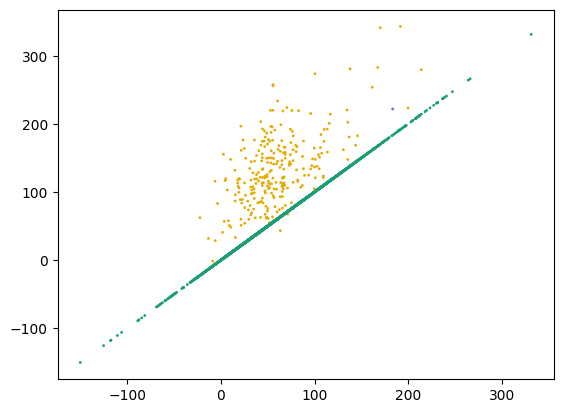

In [34]:
d = data[data.last_calc_day_cat == 0]
d = d.sample(n=3000,replace=True)

colormap = "Dark2"
plt.figure(); plt.scatter(d.last_ytw, d.ytw, s=1, c = d.calc_day_cat, cmap=colormap)
plt.figure(); plt.scatter(d.last_yield_spread, d.yield_spread, s=1, c = d.calc_day_cat, cmap=colormap)
plt.figure(); plt.scatter(d.last_yield_spread, d.same_ys, s=1, c = d.calc_day_cat, cmap=colormap)
plt.figure(); plt.scatter(d.yield_spread, d.same_ys, s=1, c = d.calc_day_cat, cmap=colormap)

Adding a feature to count how many identical trades happened earlier the same day.
Ideally this feature would take into account publish times, to avoid leakage,
but it is not an important predictor, so this does not matter much.

In [35]:
gby = data.groupby(['trade_date', 'cusip', 'quantity', 'dollar_price', 'trade_type'])
%time data['cumcount'] = gby.cumcount()
# data.cumcount.value_counts()

CPU times: user 6.82 s, sys: 3.01 s, total: 9.83 s
Wall time: 9.84 s


If a trade is duplicated more than 100 times, that is likely a data processing error.

In [36]:
d = data[data.cumcount > 100]
cols = ['cusip', 'trade_datetime', 'cumcount', 'par_traded', 'yield_spread', 'dollar_price', 'last_dollar_price', 'last_seconds_ago']
d[cols]

,cusip,trade_datetime,cumcount,par_traded,yield_spread,dollar_price,last_dollar_price,last_seconds_ago


#### The issuer of a bond

The first six characters of a cusip are a unique identifier for the entity that issues a bond. 
Unfortunately, we do not yet know the feature engineering that makes this feature useful.
Learning a vector embedding for it directly, or giving it directly to LightGBM, makes accuracy worse.
Issuer 13063D is the state of California.
The "groupby" average confirms that issuer and ice_organization_id are in 1-1 correspondence.

In [37]:
# droplist = ['id', 'seq_num', 'sequence_number', 'rtrs_control_number', 'coupon', 'issue_key_copy']
# droplist = droplist + ['target_attention_features', 'yield', 'call_date_notice', 'call_cav']
# droplist = droplist + ['A/E', 'q', 'd', 'scaled_accrued_days']

# data = data.drop(droplist, axis=1, errors='ignore')

data['issuer'] = data.cusip.str[:6].astype('category')
if "ice_organization_id" in data.columns:
    print( data.groupby('issuer').ice_organization_id.nunique().mean() )
data.issuer.describe()

1.0


count     4749121
unique      21718
top        13063D
freq        52582
Name: issuer, dtype: object

#### Discrete values of a continuous variable that occur unusually often

To do: Investigate why 4% and 3% exactly are more common values for yield to worst (YTW) than 5%.

In [38]:
data.ytw.value_counts()

400.0    32949
300.0    23803
250.0    14172
399.9    13786
350.0    12697
310.0    12656
325.0    12556
         ...  
67.1         1
745.5        1
763.4        1
849.5        1
670.6        1
713.7        1
30.8         1
Name: ytw, Length: 8684, dtype: int64

We prefer primary_market_settlement_date to dated_date.
Note that days_to_calc is a leaker, since calc_date is a leaker.
days_duration is a variant of calc_date without leakage.

Note also that calculations using "dt.days" and 365.25 are only approximate, because MSRB rule 33-G says to use the 360/30 convention.

In [39]:
data['days_to_calc'] = (data.calc_date - data.settlement_date).dt.days

#### Investigating our yield curve levels

The distribution of ficc_ycl is multimodal, with the mode around 370 bps corresponding to maturities over 12 years.
To do: Find out why the distribution of ficc_ycl has spikes, especially the large spike around 325 bps.

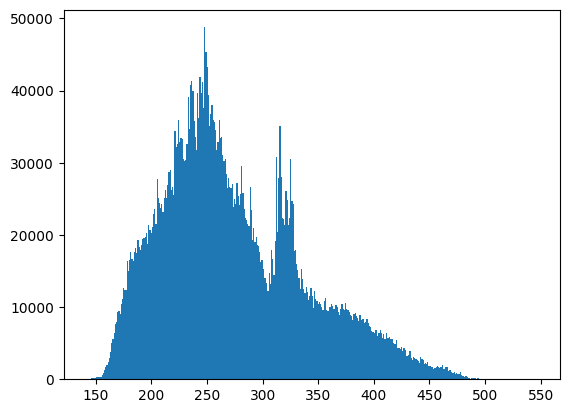

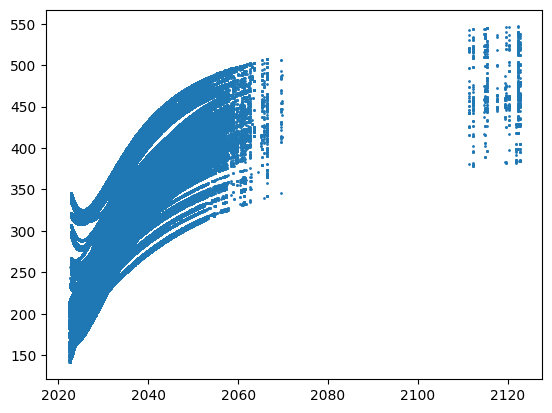

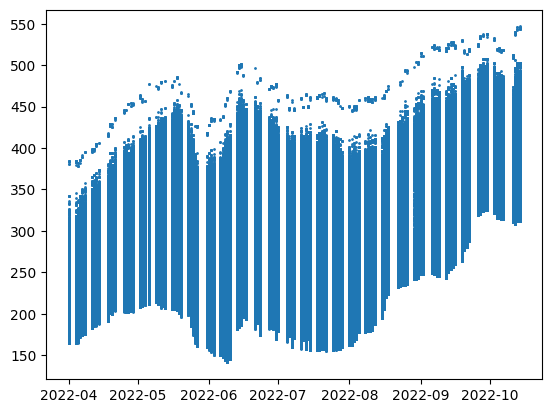

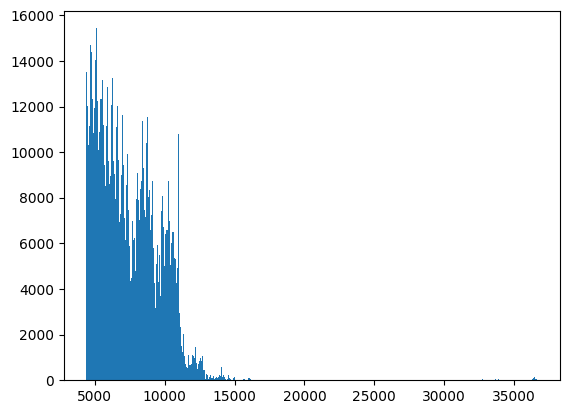

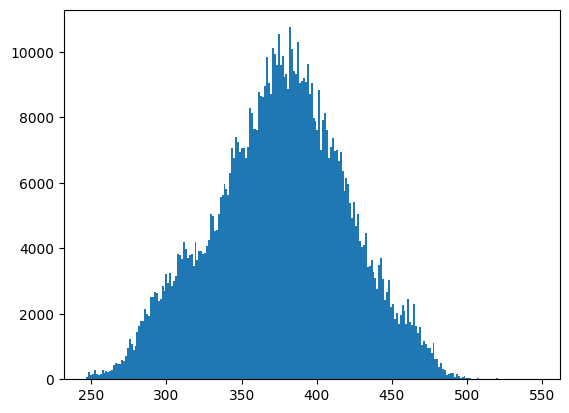

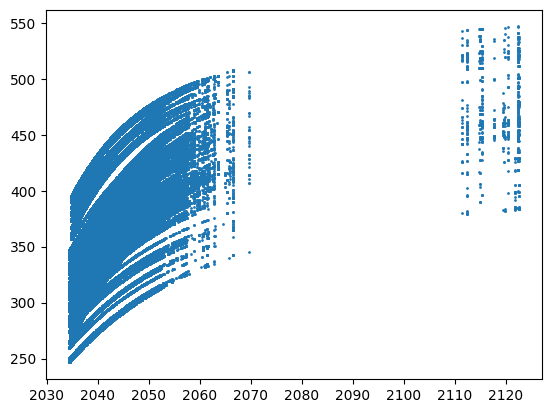

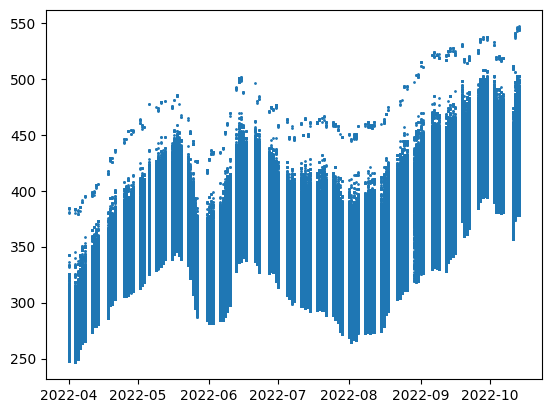

In [40]:
d = data

plt.figure(); plt.hist(d.ficc_ycl,bins='auto');
plt.figure(); plt.scatter(d.calc_date, d.ficc_ycl, s=1)
plt.figure(); plt.scatter(d.trade_date, d.ficc_ycl, s=1);

d = d[(d.days_to_calc > 12*365.25)]
plt.figure(); plt.hist(d.days_to_calc,bins='auto');

plt.figure(); plt.hist(d.ficc_ycl,bins='auto');
plt.figure(); plt.scatter(d.calc_date, d.ficc_ycl, s=1)
plt.figure(); plt.scatter(d.trade_date, d.ficc_ycl, s=1);

#### How many different calc dates does each cusip have?

Zero counts are due to cusips that are defined in the set of categorical values, but absent in the data. 
Multiple calc_dates are most often due to the calc date being one month in the future when the bond is callable soon.
Cusip 6461393P8 has the highest number of different calc dates.

In [41]:
%%time
dgc = data.groupby('cusip', observed=True)
print( dgc.calc_day_cat.nunique().value_counts() )
dg = dgc.calc_date.nunique()
print( dg.value_counts() )
dg[dg >= 12]

1    256417
2     33767
3        50
Name: calc_day_cat, dtype: int64
1     256701
2      32973
3        376
4         88
5         31
6         20
8         10
7         10
9          8
10         5
11         4
12         4
14         3
13         1
Name: calc_date, dtype: int64
CPU times: user 3 s, sys: 75.8 ms, total: 3.07 s
Wall time: 3.08 s


cusip
246387SS4    14
452152JS1    12
62947YAD3    12
6461393P8    14
73358WFW9    14
73358WFY5    12
796334AS9    12
95639REX3    13
Name: calc_date, dtype: int64

To do: For each numerical feature, find the root transformation that makes it most symmetric, after removing zeros as a special case.
Idea: Compare the median and mean to determine the root.
For example, for accrued_days, a square root transform is reasonable.
Reminder: Jensen's inequality makes predictions be biased too low when the target is root or log transformed.

1244.0 1476.1019159982793


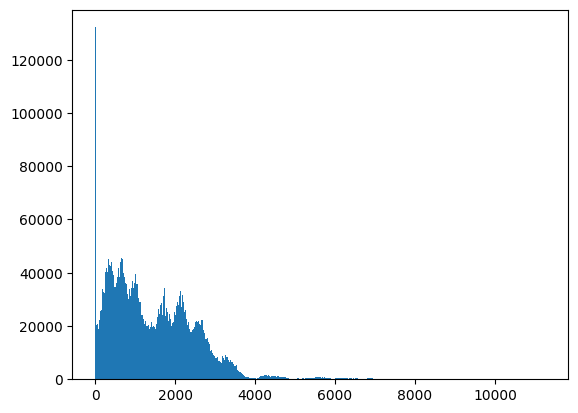

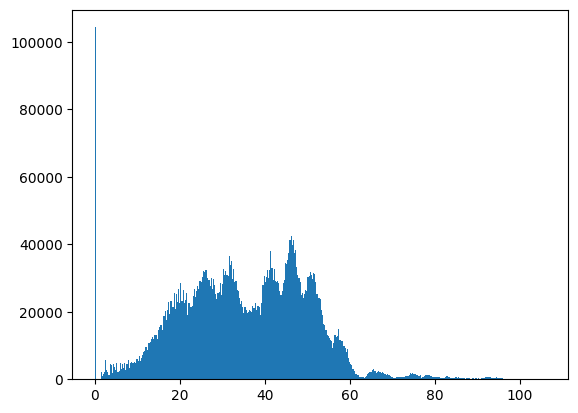

In [42]:
d = data.accrued_days
print(d.median(), d.mean() )
plt.figure(); plt.hist( d, bins='auto');
plt.figure(); plt.hist( d**(1/2), bins='auto');

#### Adding fields that condition on calc date

These fields should be used only to investigate accuracy,
and not as predictors, since calc_date is a leaker.

We expect accuracy to be worse when the calc date is uncertain,
and in particular when the current calc date is different from the previous calc date.
The new column "status" captures this.

- When status is earlier, then calc_day_cat is usually 0, next call date.
- calc_day_cat = 1 means par call date.
- When status becomes later, then calc_day_cat is usually 2, maturity date.
- When status becomes called, then calc_day_cat is usually 3, refund date.

Even in April to June, when the yield curve moved a lot, the calc date changed for fewer than 3\% of all trades.
This implies that calc date uncertainty cannot be the only major source of error.

To do: Investigate the unexpected combinations of "status" and calc_day_cat.

In [43]:
calcdiff = (data.calc_date - data.last_calc_date).dt.days
data['status'] = "same"
data.loc[ calcdiff > 14,  'status' ] = "later"
data.loc[ calcdiff < -14, 'status' ] = "earlier"
data.loc[ data.called, 'status' ] = "called"    # overrides other statuses

pd.crosstab(data.status, data.calc_day_cat)

calc_day_cat,0,1,2,3
status,,,,
called,10,0,3,135820
earlier,92197,558,3,0
later,578,477,185405,0
same,1912662,2985,2418423,0


The column named days_duration is a feature that avoids leakage, that captures the duration until the likely calc date.
This feature turns out to be an important predictor.

To do: Figure out why the distribution of days_duration has a peak around the start and end of each year.
This pattern is similar for all years of duration, and for all four values of (last) calc_day_cat.
Does it have an influence on price?

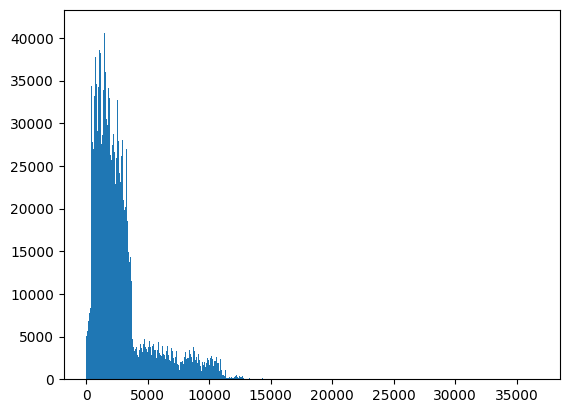

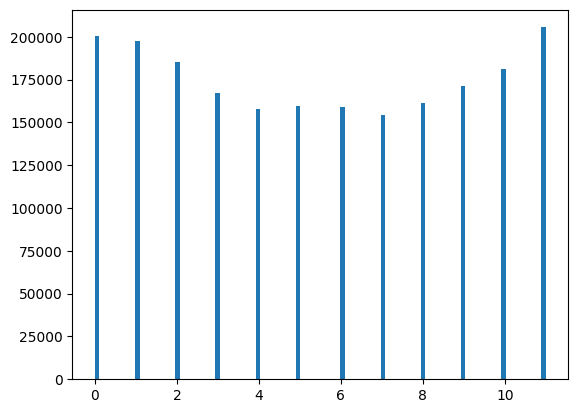

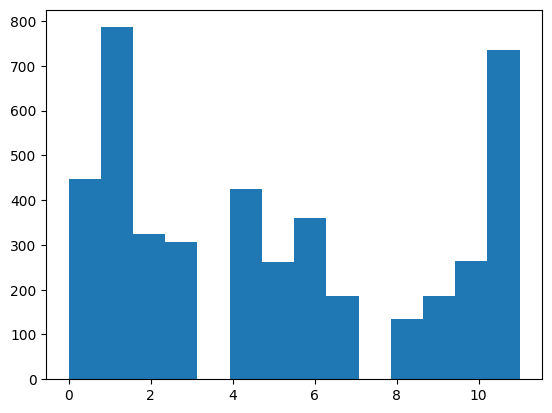

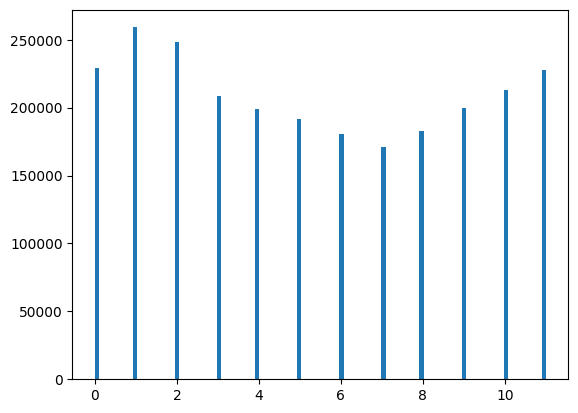

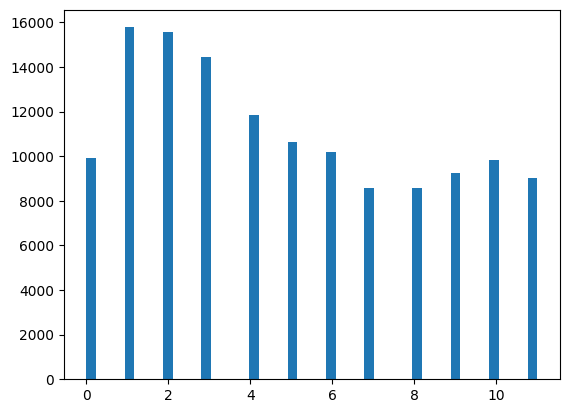

In [44]:
data['days_duration'] = (data.last_calc_date - data.last_settlement_date).dt.days
plt.figure(); plt.hist(data.days_duration, bins='auto')

data['yrs_duration'] = np.round(data.days_duration / 365.25)
data['last_calc_month'] = np.floor(12*np.remainder(data.days_duration,365.25)/365.25)

for j in {0,1,2,3}:
    d = data[data.last_calc_day_cat == j]
    plt.figure(); plt.hist(d.last_calc_month,bins='auto');

Most of the extremely high values of YTW are for trades very close to the refund date.
The cusip was trading around par in February of 2021, but the price dropped to 37.25 when they failed the audit.

To do: Investigate cusip 967249PV9 also, which is the only other bond with YTW over 25%,
given the 400 day exclusions imposed above.
<!-- - The trades in cusip 91412G6X8 were just days before the refund date. -->

In [45]:
d = data[data.ytw > 2500]
# d = data[data.cusip == "476251AB9"]

cols = ['cusip', 'trade_date', 'settlement_date', 'ytw', 'refund_date', 'calc_date', 'dollar_price', 'quantity', 'trade_type']
d[cols]

,cusip,trade_date,settlement_date,ytw,refund_date,calc_date,dollar_price,quantity,trade_type
609985,967249PW7,2022-09-27,2022-09-29,2639.6,NaT,2026-12-01,46.500,4.176,D
609987,967249PW7,2022-09-27,2022-09-29,2639.6,NaT,2026-12-01,46.500,4.176,S
792357,967249PV9,2022-09-20,2022-09-22,3121.4,NaT,2025-12-01,48.000,4.176,D
792359,967249PV9,2022-09-20,2022-09-22,3121.4,NaT,2025-12-01,48.000,4.176,S
1375506,476251AB9,2022-08-25,2022-08-29,9080.5,NaT,2023-11-01,44.687,4.544,D
1375597,476251AB9,2022-08-25,2022-08-29,8940.1,NaT,2023-11-01,45.187,4.544,D
1376656,476251AB9,2022-08-25,2022-08-29,9137.3,NaT,2023-11-01,44.487,4.544,P
1503714,476251AB9,2022-08-22,2022-08-24,7437.8,NaT,2023-11-01,50.687,4.176,D
1503715,476251AB9,2022-08-22,2022-08-24,7485.1,NaT,2023-11-01,50.484,4.176,P
2433641,967249PW7,2022-07-12,2022-07-14,2722.7,NaT,2026-12-01,43.787,4.176,D


Nothing seems wrong when par_price < refund_price. If par_price > refund_price, then par_price = issue_price.

In [46]:
d = data[(data.par_price > data.refund_price) & (d.par_price != d.issue_price)]
cols = ['cusip', 'trade_date', 'ytw', 'refund_date', 'calc_date', 'refund_price', 'dollar_price', 'quantity', 'par_price', 'issue_price']
d[cols]

,cusip,trade_date,ytw,refund_date,calc_date,refund_price,dollar_price,quantity,par_price,issue_price


To do: Investigate the small cells in the following table. 
Hypothesis: These involve bonds that are very close to being repaid.

In [47]:
pd.crosstab(~pd.isnull(data.next_call_date), [data.callable, data.called, data.called_redemption_type])

callable                  False                                               True        
called                    False                        True                   False       
called_redemption_type     0.0  1.0    5.0  18.0  19.0  6.0     13.0  17.0     0.0    19.0
next_call_date                                                                            
False                   1503005    6  15333  128  8005     0    1100     1        0      0
True                          0    0     11   92     0  1613  132050  1069  3076664  10044

When "callable" changes, usually that is because the bond has been called, or data has been updated before issuance. 
A few cusips are exceptions.
From a team member: "These CUSIPs are not yet callable but have an option of being redeemed on any date after a pre-specified date in the prospectus. 
The next call date for these bonds is the date specified in the prospectus after which they can be called at any time. 
An example of this type is 59259YWG0 (look at page 11)."

In [48]:
w = data[~data.called & ~data.whenissued].groupby('cusip').callable.nunique() > 2
w.sum()

0

Cusip 837151L80 was callable on May 11, then not callable from May 16 to May 25, then callable again on May 27 and after.
It seems that either ICE screwed up or that they received faulty information from the issuer."

In [49]:
# data[data.cusip == "837151L80"][['trade_datetime', 'par_traded', 'calc_date', 'callable', 'next_call_date', 'called']]

If the price increases, then the calc date stays the same or gets earlier. 
Exceptions are when the next call date has jumped further into the future by a multiple of six months.

If the price decreases, then the calc date stays the same or gets later. 
The three exceptions may be due to rounding errors connected with a price of 100.0 versus 99.999.

In [50]:
d = data[(data.dollar_price > data.last_dollar_price + 3) & (data.status == 'later')]
# d = data[(data.dollar_price < data.last_dollar_price) & (data.status == 'earlier')]

print( d[['cusip', 'trade_date', 'last_dollar_price', 'last_calc_date', 'calc_date', \
          'calc_day_cat', 'dollar_price', 'next_call_price']] )

             cusip trade_date  last_dollar_price last_calc_date  calc_date  calc_day_cat  dollar_price  next_call_price
557599   179390MZ9 2022-09-28             75.328     2025-06-15 2028-06-15             2        79.320           88.745
967722   157411RY7 2022-09-14             65.451     2028-08-01 2033-08-01             2        71.080           86.039
967724   157411RY7 2022-09-14             65.451     2028-08-01 2033-08-01             2        71.580           86.039
2022410  88283NAD4 2022-07-28             52.181     2031-02-01 2034-08-01             2        59.108           80.893
4614407  777849SS0 2022-04-26             70.750     2027-02-01 2029-08-01             2        75.826           91.534
4614408  777849SS0 2022-04-26             70.750     2027-02-01 2029-08-01             2        75.826           91.534
4614412  777849SS0 2022-04-26             70.750     2027-02-01 2029-08-01             2        75.257           91.534
5202328  488224DL7 2022-04-05           

#### Features based on time and day

Trades happen at every hour of the day. We see that trades are never reported on weekends.
There are fewer trades on Fridays and Mondays.
Interesting finding later: accuracy is worst on Mondays, improves monotonically, and is best on Fridays.

In [51]:
dt = pd.to_datetime(data.trade_datetime).dt

data['hour_of_day'] = dt.hour.astype('category')
print( data.hour_of_day.value_counts().sort_index() )

data['weekday'] = dt.day_name().astype('category')
data.weekday.value_counts()

0        125
1         26
2         30
3         23
4          6
5         82
6         68
7      12442
8     122182
9     310528
10    529649
11    700300
12    708188
13    722740
14    690833
15    611941
16    322206
17     15218
18      1762
19       336
20       402
21         9
22        18
23         7
Name: hour_of_day, dtype: int64


Tuesday      1145815
Wednesday    1120957
Thursday      986686
Monday        782108
Friday        713555
Name: weekday, dtype: int64

#### Investigating dates

Many dates in the data have already been used to compute useful features, such as _days__to__settle_.

Notes on dates:
- dated_date, issue_date, delivery_date, formal_award_date, sale_date are legal concepts that do not have direct financial implications.
- first_execution_date is empirical 
- accrual_date and primary_market_settlement_date are important financially, so our feature engineering should be based on these.

In the data, empirically:
- dated_date and issue_date are not identical, but always close.
- formal_award_date (sometimes unknown) and sale_date are not identical, but almost always close
- dated_date and issue_date can be before or much after sale_date and formal_award_date
- accrual_date, primary_market_settlement_date, delivery_date are not identical, but always close.
- first_execution_date is often before primary_market_settlement_date.

#### A few additional predictors

The existing field _when__issued_ is almost identical with _new__issue_. 
The exceptions include trades in a refunding bond, cusip 455054BH8, and we know that these bonds are complicated.
The existing field _whenissued_ should be discarded.

Par issues are unusual. Most bonds are issued at a price above par.
More than half of all trades are in bonds that are callable at \$100 and have not yet been called.

To do: Write a function that automatically analyzes cells with small counts in a cross-tabulation.

In [52]:
data['par_issue'] = data.issue_price == 100
data['prev_trade_today'] = (data.last_seconds_ago > 0) & (data.last_seconds_ago <= 4.5)

if 'is_lop_or_takedown' in data.columns:
    data['is_takedown'] = data.is_lop_or_takedown & (data.dollar_price < data.issue_price)
    data['is_lop'] = data.is_lop_or_takedown & (data.dollar_price == data.issue_price)

if 'primary_market_settlement_date' in data.columns:
    data['new_issue'] = data.trade_date < data.primary_market_settlement_date
    print( pd.crosstab(data.new_issue, data.when_issued), "\n" )
    print( pd.crosstab(data.new_issue, data.whenissued) )
    data['days_from_issue'] = (data.trade_date - data.primary_market_settlement_date).dt.days

when_issued    False   True 
new_issue                   
False        4642307       0
True             191  106623 

whenissued    False   True 
new_issue                  
False       4638304    4003
True              0  106814


To do: Investigate why whenissued, when\_issued, and new \_issue are not identical.

Next, we drop all columns that are constant. 
The argument nunique(dropna=False) allows NaN to be a possible unique value.
To do: Check whether any columns have identical values. 
In principle, this can be done with data.T.drop_duplicates().T, but there are problems in practice, including but not limited to inefficiency.

In [53]:
%%time
for col in data.columns:
    try: 
        if data[col].nunique(dropna=False) <= 1:
            print(col)
            data = data.drop(col, axis=1)
    except Exception as ex: pass

MSRB_INST_ORDR_DESC
MSRB_valid_to_date
version
unable_to_verify_dollar_price
is_trade_with_a_par_amount_over_5MM
next_put_date
sp_Credit_Watch_Short_Rating
moodys_Credit_Watch_Long_Outlook_Rating
sink_indicator
default_exists
floating_rate_exists
debt_type
default_indicator
additional_state_code
designated_termination_date
most_recent_default_event
days_since_most_recent_default_event
price_yield_reporting_error
CPU times: user 1min 49s, sys: 1min 3s, total: 2min 53s
Wall time: 3min


We convert all string fields into categorical, to save memory and (later) to enable vector embeddings.
_last__trade__date_ and _par__traded_ have erroneous types in the data file.
To do: Actual natural language processing on the strings.

In [54]:
%%time
try: data['last_trade_date'] = data['last_trade_date'].astype('datetime64[ns]')
except Exception as _: pass

data['par_traded'] = data.par_traded.astype('float64')

for col in data.select_dtypes(include=['object']).columns.tolist():
    try: 
        data[col] = data[col].astype('category')
        print(col, data[col].nunique())
    except Exception as _: 
        print(col, "not made discrete")

MSRB_coupon_rate 4692
msrb_cusip 290234
series_id 62015
trade_type 3
transaction_type 3
security_description 49845
time_of_trade 39034
brokers_broker 2
publish_time 39912
cusip 290234
incorporated_state_code 54
organization_primary_name 21249
instrument_primary_name 21373
issue_text 7721
conduit_obligor_name 2277
call_defeased 3
extraordinary_redemption 2
redemption_cav_flag 2
sp_Short_Rating 5
sp_Recovery_Long_Rating 7
moodys_short 6
moodys_Issue_Long_Rating 20
moodys_Issue_Short_Rating 6
moodys_Credit_Watch_Long_Rating 3
moodys_Credit_Watch_Short_Rating 1
moodys_Enhanced_Long_Rating 18
moodys_Enhanced_Short_Rating 2
sink_amount_type_text 8
sink_amount_type_type 8
escrow_obligation_agent 98
bond_insurance 55
interest_payment_frequency 2
additional_project_txt 10348
mtg_insurance 14
other_enhancement_company 16
pac_bond_indicator 1
project_name 4391
series_name 2829
use_of_proceeds_supplementary 500
moodys_long 22
sp_long 21
sp_stand_alone 18
sp_icr_school 14
sp_prelim_long 5
sp_outloo

#### Filling in values when none is known

We have tried code that guesses when the most common known value (the mode) should be filled in, instead of a new special value,
but these heuristics can be wrong, and don't clearly improve accuracy.
The current special value is -1.0 for all fields that are not datetimes, because this value is compatible with multiple field types.

To do: Investigate fields that get filled with "no" if any. Fill -1.0 for all numerical types.

In [55]:
%%time
for name in data.columns:
    col = data[name]
    nnan = col.isna().sum()
    if nnan == 0: continue
        
    vctop = col.value_counts(dropna=False)
    if len(vctop) <= 1: 
        print(f"Warning: {name} {nnan} {len(vctop)}\n")
        continue

    mode = vctop.index.tolist()[0]
    count = vctop.tolist()[0]
    dt = str(col.dtype)
    nu = col.nunique()
    known = len(col) - nnan

    if dt == 'float64':
        fillval = -1.0
        data[name] = col.fillna(fillval)
    elif dt == 'category': 
        fillval = -1.0
        data[name] = col.cat.add_categories(fillval).fillna(fillval)
    elif dt[0:8] == "datetime":
        fillval = pd.to_datetime('1900-01-01')
    else:
        fillval = "no"
   
    base = f"{name:32} {dt:17} \t{known:7} known \t{nu:7} unique \tmode {str(mode):10.10} {count:7}  fill {str(fillval):10.10}" 
    print(base)

assumed_settlement_date          datetime64[ns]    	      4 known 	      4 unique 	mode NaT        4749117  fill 1900-01-01
settlement_date                  datetime64[ns]    	4749117 known 	    157 unique 	mode 2022-10-13   54927  fill 1900-01-01
brokers_broker                   category          	  62900 known 	      2 unique 	mode nan        4686221  fill -1.0      
conduit_obligor_name             category          	 259386 known 	   2277 unique 	mode nan        4489735  fill -1.0      
called_redemption_date           datetime64[ns]    	 151183 known 	    194 unique 	mode NaT        4597938  fill 1900-01-01
first_call_date                  datetime64[ns]    	3223026 known 	    794 unique 	mode NaT        1526095  fill 1900-01-01
call_defeased                    category          	   2092 known 	      3 unique 	mode nan        4747029  fill -1.0      
extraordinary_redemption         category          	3524218 known 	      2 unique 	mode False      2764133  fill -1.0      
next_cal

Columns with exactly two values are converted into Booleans.
dropna=False should be redundant, since unknown values have been filled in above.
To do: Look at columns with exactly three unique values. Convert some to Boolean, and make others into one-hot encoding.

In [56]:
%%time
for col in data.columns:
    try:
        if data[col].nunique(dropna=False) == 2:
            print(col)
            data[col] = data[col].astype('bool')
    except Exception as _: pass

when_issued
is_weighted_average_price
is_lop_or_takedown
is_alternative_trading_system
is_non_transaction_based_compensation
is_called
is_callable
callable_at_cav
extraordinary_make_whole_call
make_whole_call
max_notification_days
min_notification_days
put_feature_price
put_frequency
put_start_date
moodys_Credit_Watch_Short_Rating
has_sink_schedule
event_exists
has_unexpired_lines_of_credit
escrow_exists
child_linkage_exists
put_exists
bond_insurance_exists
is_general_obligation
has_zero_coupons
outstanding_indicator
interest_payment_frequency
settlement_type
bank_qualified
conditional_call_price
pac_bond_indicator
sp_watch_long
callable
called
zerocoupon
whenissued
sinking
deferred
days_in_interest_payment
is_replica
is_bookkeeping
is_same_day
ntbc_precursor
par_issue
prev_trade_today
is_takedown
is_lop
new_issue
CPU times: user 12.7 s, sys: 2.38 s, total: 15.1 s
Wall time: 15.1 s


Many numerical fields are actually categorical, so we convert them.
Dictionaries explaining the values of categorical fields are in https://docs.google.com/spreadsheets/d/172OKmkParOjg9r-N4qWjoTdPxQIZoJ1z/edit#gid=655976637.

In [57]:
%%time
minvalues = 30

candidates = data.select_dtypes(include=[np.number])
candidates = set(candidates.columns) - { 'de_minimis_threshold', 'num_prev_messages', 'days_to_settle' }

for col in candidates:
    nun = data[col].nunique(dropna=False)
    if nun < minvalues and not "refund" in col and not "ycl" in col and not "price" in col:
        print(col, nun)
        data[col] = data[col].astype('category')

third_mandatory_redemption_code 11
years_to_loc_expiration 4
tax_credit_percent 9
sink_defeased 3
sink_frequency 4
capital_type 14
muni_security_type 17
available_denom 3
muni_issue_type 12
state_tax_status 4
federal_tax_status 3
call_timing_in_part 6
secured 5
calc_day_cat 4
sink_fund_redemption_method 5
first_mandatory_redemption_code 12
put_type 3
last_calc_month 13
last_calc_day_cat 5
tax_credit_frequency 4
sink_amount_type 6
min_denom_amount 14
second_optional_redemption_code 9
DTCC_status 4
coupon_type 6
third_optional_redemption_code 8
escrow_obligation_type 10
orig_cusip_status 4
sale_type 6
call_timing 6
called_redemption_type 8
maturity_description_code 8
second_mandatory_redemption_code 13
daycount_basis_type 5
orig_instrument_enhancement_type 6
denom_increment_amount 10
asset_claim_code 6
additional_sink_frequency 4
sec_regulation 3
maximum_call_notice_period 14
first_optional_redemption_code 12
CPU times: user 18.3 s, sys: 13 s, total: 31.3 s
Wall time: 32.5 s


#### Adding target trade features to calculate attention

These features are not used by LightGBM models.
For neural network models, as a first step, we use only the size of the trade and the direction as features to calculate attention. 
When we use trades in different but related cusips, we will add more features like the state code, coupon, interest payment frequency, etc. 

Pandarallel uses too much memory and too much time because it copies all data once for each worker.
It is fastest with just 2 workers, and not faster than regular pandas.
The code below is 20 times faster than using "apply." 

In [58]:
%%time
SEQUENCE_LENGTH = 5

# trade_mapping = {'D':[0,0], 'S':[0,1], 'P':[1,0]}
# def target_trade_processing_for_attention(row):
#     target_trade_features = [ row.quantity ] + trade_mapping[row.trade_type]
#     return np.tile(target_trade_features, ( SEQUENCE_LENGTH,1 ))
# data['target_attention_features'] = data.apply(target_trade_processing_for_attention, axis = 1)

m1 = {'D':0, 'S':0, 'P':1}
m2 = {'D':0, 'S':1, 'P':0}

# c = pd.concat([ data.quantity, data.trade_type.map(m1), data.trade_type.map(m2) ], axis=1)
# m = c.values.tolist()
# n = [np.array( [target_trade_features]*SEQUENCE_LENGTH ) for target_trade_features in m ]
# data['target_attention_features'] = n

# data.iloc[100]['target_attention_features']

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


#### Features to capture changes in a bond's characteristics

Changes in yield curve level have some slight predictive power.

In [59]:
data['diff_maturity'] = data.maturity_date != data.last_maturity_date
data['diff_next_call'] = data.next_call_date != data.last_next_call_date
data['diff_par_call'] = data.par_call_date != data.last_par_call_date

if 'refund_date' in data.columns:
    data['diff_refund'] = data.refund_date != data.last_refund_date

if 'last_ficc_ycl_to_maturity' in data.columns:
    data['diff_ycl_to_maturity'] = data.ficc_ycl_to_maturity - data.last_ficc_ycl_to_maturity
    data['diff_ycl_to_next_call'] = data.ficc_ycl_to_next_call - data.last_ficc_ycl_to_next_call
    data['diff_ycl_to_par_call'] = data.ficc_ycl_to_par_call - data.last_ficc_ycl_to_par_call
    data['diff_ycl_to_refund'] = pd.to_numeric(data.ficc_ycl_to_refund) - pd.to_numeric(data.last_ficc_ycl_to_refund)

data['diff_size'] = data.quantity.astype(float) - data.last_size.astype(float)
data[data.last_size == 0]['diff_size'] = -99
data['abs_diff_size'] = np.abs(data.diff_size)

In [60]:
ds = data.select_dtypes(include=[np.number])
for col in ds.columns:
    vals = data[col]
    vals = vals[vals != -1]
    if ((vals < 0).mean() > 0.001) and ((vals > 0).mean() > 0.001):
        newcol = 'abs_' + col
        data[newcol] = np.abs(vals)
        print(newcol)
    # zeros = vals == 0
    # if zeros.mean() >= 0.001:
    #     newcol = 'zero_' + col
    #     data[newcol] = zeros
    #     print(newcol)

abs_yield_spread
abs_last_yield_spread
abs_ficc_treasury_spread
abs_t_rate_diff_1
abs_t_rate_diff_2
abs_t_rate_diff_3
abs_t_rate_diff_5
abs_t_rate_diff_7
abs_t_rate_diff_10
abs_t_rate_diff_20
abs_t_rate_diff_30
abs_last_ficc_ycl_to_refund
abs_corporate_spread
abs_same_ys
abs_ycl_diff
abs_days_from_issue
abs_diff_ycl_to_maturity
abs_diff_ycl_to_next_call
abs_diff_ycl_to_par_call
abs_diff_ycl_to_refund
abs_diff_size


#### Investigating remaining null values

After the feature engineering above, no fields except datetimes should have null values.
We create a Boolean flag for each field that has null values.

To do: Investigate when the last trade is null.

In [61]:
%%time
for col in data.columns:
    if data[col].isnull().any():
        print(col)
        data["has_" + col] = data[col].notnull()

assumed_settlement_date
settlement_date
called_redemption_date
first_call_date
next_call_date
par_call_date
refund_date
put_end_date
next_sink_date
additional_next_sink_date
delivery_date
first_coupon_date
last_period_accrues_from_date
next_coupon_payment_date
odd_first_coupon_date
previous_coupon_payment_date
conditional_call_date
first_execution_date
formal_award_date
refunding_dated_date
last_calc_date
last_maturity_date
last_next_call_date
last_par_call_date
last_refund_date
last_trade_datetime
last_settlement_date
last_trade_date
abs_last_yield_spread
abs_last_ficc_ycl_to_refund
abs_same_ys
abs_ycl_diff
abs_days_from_issue
CPU times: user 1.06 s, sys: 67.2 ms, total: 1.13 s
Wall time: 1.13 s


#### Information about the most recent trade may be unavailable in production
<!-- 
For cusip 835631NS7, look at the row with trade time 2022-05-13 14:10:04.
This has last_seconds_ago = 1.813, so the last trade was only 10^1.813 = 65 seconds before. 
But no such trade appears in the data. Surely it should? -->

For cusip 835631NS7, look at the row with trade time 2022-05-16 11:10:09. 
The datetime of the last trade is the same day at 11:08:59. 
Indeed, this trade is in the row immediately above (the one second difference is a rounding error). 
But, the publish time for this trade was 11:10:19. 
Therefore it was not visible at 11:10:09, and using the value for last_yield_spread is leakage.

In [62]:
# import datetime
# c = data[(data.cusip == "835631NS7")]
# c['d'] = c.apply(lambda z: z.trade_datetime - datetime.timedelta(seconds = 10**z.last_seconds_ago), axis=1)
# # cols = ['cusip', 'trade_datetime', 'publish_datetime', 'yield_spread', 'last_yield_spread', 'last_seconds_ago']
# cols = ['cusip', 'trade_datetime', 'yield_spread', 'last_yield_spread', 'last_seconds_ago']
# if 'publish_datetime' in data.columns:
#     cols.append('publish_datetime')
# # c[cols + ['d']]

#### Features not to use

Print a representative value for columns that have discrete values.
Note that the models below do not use features with more than "maxdiscrete" discrete values.

In [63]:
data['day_of_year'] = data.trade_date.dt.dayofyear
data['ted_spread'] = (data.t_rate_10 - data.t_rate_2) * 100

In [64]:
maxdiscrete = 100

ds = data.select_dtypes(include=['category'])
TOOMANY = set()
for col in ds.columns:
    nun = data[col].nunique()
    vc = data[col].value_counts()
    vals = vc.index.to_numpy()
    third = vals[2]
    print(f"{col:32s} {nun:10}   {str(third):20s}")
    if nun >= maxdiscrete: TOOMANY = TOOMANY | {col}

LEAKERS = { 'calc_day_cat', 'calc_date_month', 'days_to_calc', 'status', 'yield_spread', 'ytw', 'yield', 'same_ys', \
           'dollar_price', 'calc_price', 'last_calc_month', 'ficc_ycl', \
           'price_to_maturity', 'price_to_next_call', 'price_to_par_call', 'floor', 'scary', \
           'abs_yield_spread', 'abs_same_ys', 'zero_yield_spread', 'zero_same_ys'}

CAT = set(ds.columns) - TOOMANY - LEAKERS

BOOLEAN = set(data.select_dtypes(include=['bool']).columns)
NUMERICAL = set(data.select_dtypes(include=[np.number]).columns)

NONCAT = (BOOLEAN | NUMERICAL) - LEAKERS

MSRB_coupon_rate                       4692   3.000000000         
msrb_cusip                           290234   546399KS4           
series_id                             62015   11844332020 A       
calc_day_cat                              4   3                   
trade_type                                3   P                   
transaction_type                          3   M                   
security_description                  49845   CALIFORNIA ST VARIOUS PURP
time_of_trade                         39034   13:53:00            
brokers_broker                            3   P                   
publish_time                          39912   06:01:01            
cusip                                290234   546399KS4           
incorporated_state_code                  54   TX                  
organization_primary_name             21249   NEW YORK N Y        
instrument_primary_name               21373   BDS 2019            
issue_text                             7721   REV BDS   

#### Finding the most recent related trade

Two different notions of related bond:
- a broad definition, such that there exists a trade in a related bond that is less than a day prior.
- a narrow definition, such that the related bond is very similar, often within the same series.

For the broad notion:
- we can limited related bonds to those with reliable prices: investment grade
- we define basic characteristics on which a related bond must be the same: state, etc.
We take the most recent trade in such a bond.
Then we need to create features for the differences with the target trade: duration, rating, coupon.

For the narrow notion, we also create features for the differences: duration

Also ensure same calc_day_cat.

In [65]:
len(data)
# data.cusip.nunique()

4749121

In [66]:
data.rating.value_counts()

AA      866844
MR      787627
AAA     721548
AA+     694771
AA-     679048
A+      410912
A       267193
A-      124677
BBB+    123019
BBB      28294
BBB-     16712
NR       16287
BB+       3994
BB        3630
BB-       2889
B-         677
B+         471
B          317
CCC+       123
CCC         49
CCC-        39
Name: rating, dtype: int64

In [67]:
good = ['AA-', 'AA', 'AA+', 'AAA']
data['inv_grade'] = data.rating.isin(good)

In [68]:
# sames = [
#     'series_id', 'security_description', 'organization_primary_name', 'instrument_primary_name', 'issue_text', 
#     'conduit_obligor_name', 'additional_project_txt', 'project_name', 'series_name', 'use_of_proceeds_supplementary'] #, 'issuer']
sames = [
    'security_description', 'conduit_obligor_name', 'additional_project_txt', 'series_name', 'issuer']

sames = ['incorporated_state_code', 'calc_day_cat', 'federal_tax_status', 'is_general_obligation', 'zerocoupon']
g = data.groupby(sames,observed=True)
# leng = len(g)
# agg = g.trade_date.nunique().mean()
# print(leng, agg, leng*agg)

g.trade_date.nunique().dot(g.trade_date.count()) / len(data)

128.8901649378906

In [69]:
sames

['incorporated_state_code',
 'calc_day_cat',
 'federal_tax_status',
 'is_general_obligation',
 'zerocoupon']

In [70]:
g.trade_date.nunique().dot(g.trade_date.count()) / len(data)

128.8901649378906

In [71]:
g.trade_date.count().sum()

4749121

#### Removing trades that may be harder to predict

We investigate additional large-scale exclusions.

In [72]:
%time saved = data

CPU times: user 2.63 s, sys: 5.85 s, total: 8.48 s
Wall time: 11.6 s


In [73]:
%time data = remove(saved, ( lambda df: df.quantity < np.log10(100000) ), "quantity < np.log10(100000)")
# %time data = remcolval(data, "trade_type", "P")

removing quantity < np.log10(100000)              78.6414%    3734776
CPU times: user 3.89 s, sys: 2.87 s, total: 6.76 s
Wall time: 6.88 s


In [74]:
nbins = 10
# %time data['last_ys_bin'] = pd.qcut(data.last_yield_spread, nbins, labels=[f'bin_{i}' for i in range(nbins)])
# data['last_ys_sq'] = data.last_yield_spread**2
# data['last_ys_pos'] = data.last_yield_spread.clip(0)

Findings: 
- Removing trades under 100,000 does not make accuracy worse on trades over 500,000.
- Removing trades with direction P and/or S does not improve accuracy.
- last_ys_bin, last_ys_sq, last_ys_pos do not improve accuracy.

#### Splitting the data into training and testing sets

If the test set is September 2022, then a previous finding is that June, July, August for training gives the best accuracy.

In [75]:
month = data.trade_date.dt.month
print( month.value_counts() )

train_dataframe = data[(month >= 4) & (month <= 7)]
test_dataframe = data[month >= 8]

print( len(train_dataframe) + len(test_dataframe), len(data) )

5     171841
6     161996
9     159270
4     148714
8     141739
7     140818
10     89967
Name: trade_date, dtype: int64
1014345 1014345


#### LightGBM benchmark model

We use LightGBM for exploration, because it is fast.
This can reveal whether some predictors are obvious leakers,
and whether a neural network is likely to provide decent accuracy.
_myLGBM_ has hyperparameters that informally balance between underfitting and overfitting for this domain.
Different random seed values can give models with accuracies that vary by more than one basis point.

Inside _gbmprep_, we remove columns that are leakers that might be included otherwise.
For this function and for _maeval_, _extra_ is a list of additional predictors.
Note that the dataframe columns added by _maeval_ persist after this function finishes.

The MAE printed by _drawpoints_ is for dealer-dealer trades of 500,000 dollars or more, 
which are what we call "true mid."
To increase the sample size, we can optionally include dealer-sells trades,
which empirically have slightly smaller MAE than dealer-dealer trades.

Importance plots based on gain are more fine-grained, 
and agree better with intuition about the relative predictive power provided by different features.

In [76]:
def myLGBM(seed = 11):
    return LGBMRegressor(max_depth=10, num_leaves=100, n_estimators=300, objective='mae', verbosity=-1, \
                        random_state = seed)
    
def gbmprep(df, extra=[]):
    global CAT, NONCAT, LEAKERS
    return df[ list((CAT | NONCAT) - LEAKERS) + extra ]


def myplotimportance(model, nfeatures = 30):
    lightgbm.plot_importance(model, importance_type="gain", precision=0, ignore_zero=False,\
                             max_num_features=nfeatures, figsize=(12,np.floor(nfeatures/6)+1))

# extend dataframe with predicted values and errors
def maeval(df, model, label, extra=[]):
    PREDS = label + "_preds"
    if model == "last":
        df[PREDS] = df["last_" + label]
    else:
        df[PREDS] = model.predict( gbmprep(df, extra) )
    delta = df[label] - df[PREDS]
    da = delta.abs()
    df[label + "_ae"] = da
    n = len(da)
    base = f"\n{label} {n} {extra} bias {delta.mean():5.2f}\t MAE {da.mean():5.2f} +/- {da.std():.2f}"
    print( base + f" ({da.std()/np.sqrt(n):.2f})\t median {da.median():5.2f}" )
    return

threshold = 2.5e6
directions = ['D']

# show predicted versus actual, and trades with the largest value of the error metric "sortby"
# label should be the column name for true values, also called the target
def drawpoints(df, label, sortby=""):
    label_preds = label + "_preds"

    label_ae = label + "_ae"
    keep = (10**df.quantity >= threshold/5) & (df.trade_type.isin(directions))
    df = df[keep]
    r, g, b = colors.to_rgb('red')
    w = np.minimum( np.array(10**df.quantity), threshold)
    opacity = w / threshold
    color = [(r, g, b, alpha) for alpha in opacity]

    plt.figure(figsize=(12,12))
    plt.scatter(df[label], df[label_preds], s=5, c=color)

    da = df[label_ae]
    n = len(da)
    print( f"\nLarge {directions} n={n}\t {label} MAE = {da.mean():.2f} +/- "\
          + f"{da.std():.2f} ({da.std()/np.sqrt(n):.2f}) median {da.median():.2f}" )
    if sortby == "": 
        sortby = label_ae
        name = label
    else:
        name = sortby
    kern = 60 + len(name)*7

    top = df.sort_values(by=[sortby], ascending=False).iloc[:100,:]
    top = top.drop_duplicates(['issuer'])

    for (bond, d, x, y, lastytw, ytw, err, lastdp, dp, side, lastside, days, lastys, back, lastsize, n) in \
                zip( top.cusip, top.trade_datetime, top[label], top[label_preds], top.last_ytw, top.ytw, top[sortby], \
                     top.last_dollar_price, top.dollar_price, top.trade_type, top.last_trade_type, top.days_duration, \
                     top.last_yield_spread, top.last_seconds_ago, top.last_size, range(100) ):
        if n >= 5: break
        print( f"{bond:9} {d:%m-%d}  back {10**back/86400:3.0f} {lastsize:3.1f}: {lastside:1}{lastytw:4.0f} ${lastdp:6.2f} dur {days:4.0f} " \
              + f"ys {lastys:4.0f}  now: {side:1}{ytw:4.0f} ${dp:6.2f}  true {x:6.2f} pred {y:6.2f} diff {x-y:7.2f}" )
        plt.scatter(x,y, s=40, c = 'green')
        if (x < y): 
            plt.annotate(name + " " + bond, (x-kern,y-2.5))
        else:
            plt.annotate(name + " " + bond, (x+10,y-2.5))
    return

#### Training a model to predict modified yield spread

CPU times: user 5min 35s, sys: 25.2 s, total: 6min
Wall time: 41.7 s

same_ys 623369 [] bias -0.28	 MAE  8.35 +/- 12.80 (0.02)	 median  4.74
CPU times: user 57.6 s, sys: 2.52 s, total: 1min
Wall time: 14.8 s

same_ys 390976 [] bias -5.66	 MAE 11.87 +/- 15.37 (0.02)	 median  7.33
CPU times: user 35 s, sys: 1.35 s, total: 36.4 s
Wall time: 8.07 s

Large ['D'] n=18181	 same_ys MAE = 10.30 +/- 13.54 (0.10) median 6.01
092792AB6 08-16  back 169 4.4: S 675 $ 91.30 dur 4869 ys  489  now: D1048 $ 67.00  true 760.70 pred 365.71 diff  395.00
927688GJ4 08-22  back   0 6.0: D 930 $ 94.50 dur  677 ys  698  now: D 922 $ 94.62  true 689.74 pred 361.56 diff  328.18
130536RG2 08-09  back   0 6.4: S1153 $ 69.50 dur 6687 ys  827  now: D1159 $ 69.15  true 833.24 pred 565.80 diff  267.45
64990ECK1 08-04  back   1 4.5: P 490 $100.03 dur  132 ys  323  now: D 177 $101.13  true   7.17 pred 179.39 diff -172.23
052476ZQ4 10-06  back   3 4.7: S 252 $100.27 dur   41 ys  -92  now: D 280 $100.20  true -57.37 pred 10

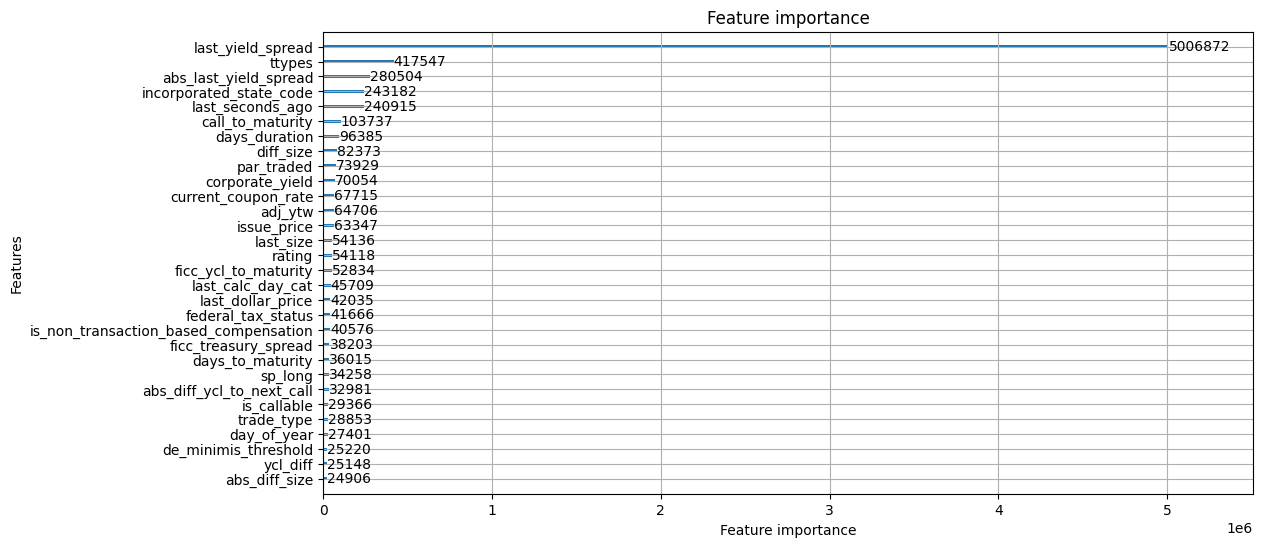

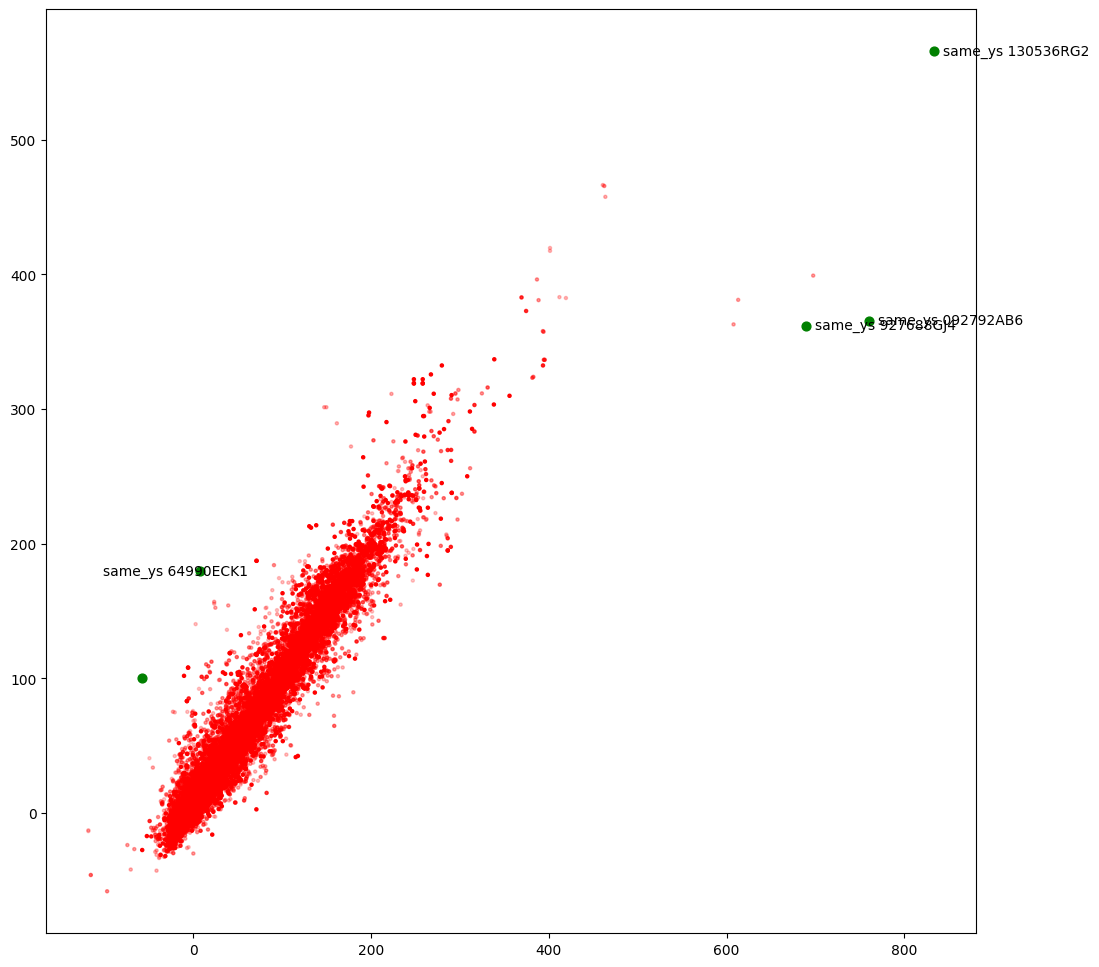

In [77]:
TARGET = 'same_ys'
extra = [] # ['last_ys_bin'] #,'last_ys_sq','last_ys_pos']

sysmodel = myLGBM(22)
%time sysmodel.fit( gbmprep(train_dataframe, extra), train_dataframe[TARGET] )

%time maeval(train_dataframe, sysmodel, TARGET, extra)
%time maeval(test_dataframe, sysmodel, TARGET, extra)

myplotimportance(sysmodel)
drawpoints(test_dataframe, TARGET)

In [78]:
df = test_dataframe.copy()


In [79]:
#for c in ['orig_principal_amount', 'purpose_sub_class','federal_tax_status','state_tax_status','use_of_proceeds','muni_security_type','muni_issue_type','capital_type','other_enhancement_type']:
#    print(f"{c}:")

df['month'] = df.trade_date.dt.month

for i in range(10):
    for j in range (8,11):
        print(f"Month {j}, Coupon:{i}, MAE: {df[(df.month == j) & (df.MSRB_coupon_rate == i)].same_ys_ae.mean()},# of trades: {df[(df.month == j) & (df.MSRB_coupon_rate == i)].same_ys_ae.count()}")

#print(df.groupby(['MSRB_coupon_rate'])['same_ys_ae'].agg(["mean","count"]).reset_index().sort_values('mean'))

Month 8, Coupon:0, MAE: 15.6770092565774,# of trades: 2330
Month 9, Coupon:0, MAE: 14.707745963255205,# of trades: 2883
Month 10, Coupon:0, MAE: 17.101725769049626,# of trades: 1328
Month 8, Coupon:1, MAE: 11.980162144771247,# of trades: 193
Month 9, Coupon:1, MAE: 17.99949567955305,# of trades: 304
Month 10, Coupon:1, MAE: 20.624830422888877,# of trades: 61
Month 8, Coupon:2, MAE: 12.52527095073347,# of trades: 2312
Month 9, Coupon:2, MAE: 14.126570280425225,# of trades: 2400
Month 10, Coupon:2, MAE: 15.215906487895108,# of trades: 1121
Month 8, Coupon:3, MAE: 10.188339933686187,# of trades: 9306
Month 9, Coupon:3, MAE: 13.01643708814704,# of trades: 8128
Month 10, Coupon:3, MAE: 13.482496088116035,# of trades: 4112
Month 8, Coupon:4, MAE: 8.150861647639303,# of trades: 41121
Month 9, Coupon:4, MAE: 9.6993378335309,# of trades: 38340
Month 10, Coupon:4, MAE: 13.252773057099645,# of trades: 18160
Month 8, Coupon:5, MAE: 10.214730231277315,# of trades: 65575
Month 9, Coupon:5, MAE: 12.1

In [80]:
#from ficc.utils.auxiliary_functions import calculate_dollar_error

from ficc.utils.diff_in_days import diff_in_days_two_dates
from ficc.utils.auxiliary_variables import NUM_OF_DAYS_IN_YEAR

def calculate_dollar_error(df):
    years_to_calc_date = diff_in_days_two_dates(df.calc_date,df.trade_date) / NUM_OF_DAYS_IN_YEAR    # the division by `np.timedelta64(NUM_OF_DAYS_IN_YEAR, 'D')` converts the quantity to years according to the MSRB convention of NUM_OF_DAYS_IN_YEAR in a year
    ytw_error = ((df['same_ys_preds'] + df['ficc_ycl']) / 100 - df['yield']) / 100    # the second divide by 100 is because the unit of the dividend is in percent
    return ytw_error * (10**df['quantity']) * years_to_calc_date 

df = test_dataframe.copy()

df['dollar_error'] = df.progress_apply(calculate_dollar_error,axis=1)



INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


100%|██████████| 390976/390976 [00:31<00:00, 12453.12it/s]


In [81]:
df['dollar_error'].min()

-15333698.810962776

In [82]:
t20 = df.sort_values(by='dollar_error',ascending=False)[:20]
b20 = df.sort_values(by='dollar_error',ascending=True)[:20]
pd.concat([t20,b20]).to_csv("myles.csv")

#### Paired test to compare two models

We want to know whether one model is more accurate than another, using the same test set for both.
A standard test compares the average accuracy of each model.
A paired test measures the mean of the difference in accuracy on each data point.
It is more powerful because randomness due to different test sets is eliminated.

With our data, z scores computed below are too large in A/A tests.
Hypothesis: z scores will be valid if distributions are Gaussian, not heavy-tailed and not bimodal.
To do: Figure out transformations that make distributions be approximately Gaussian.

In [83]:
def zscore(v):
    mu = v.mean()
    n = len(v) + 1
    stderror = v.std() / np.sqrt(n)
    zscore = mu / stderror
    # print(mu, stderror, n)
    return mu, zscore

#### Which subsets of features are useful?

From above, it is surprising that none of the Treasury rate features are among the top 30 most predictive.

To investigate the benefit of given feature sets, we add all columns whose name begins with given prefixes to LEAKERS, 
which is the set of predictors not to use, then train an otherwise identical model.
After training, we remove the same columns from LEAKERS.

It is vital to take seriously the standard error printed alongside each MAE number.
Differences that are smaller than twice the standard error can easily be due to randomness.

In [84]:
def addremove(which, subset, df, prefix):
    for col in df.columns:
        if col.startswith(prefix):
            if which == "union":
                if col in subset: 
                    print("already has", col)
                else:
                    subset = subset | { col }
                    # print("added", col)
            elif which == "minus":
                if not col in subset: 
                    print("missing", col)
                else:
                    subset = subset - { col }
                    # print("removed", col)
    return subset

def paired(df, model, label):
    base_preds = label + "_preds"
    base_ae = label + "_ae"
    
    keep = (10**df.quantity >= 5e5) & (df.trade_type.isin(['D','S']))
    df = df[keep]
    
    new_preds = model.predict( gbmprep(df, []) )
    new_ae = (df[label] - new_preds).abs()
    
#     which = (df[base_ae] < new_ae).astype('category')
#     plt.figure(figsize=(12,12))
#     plt.scatter(df[label] - df[base_preds], df[label] - new_preds, s=9, c = which, cmap="Dark2")
#     plt.figure(figsize=(12,12)); plt.scatter(df[base_ae], new_ae, s=2);

    # positive diff_ae means the new model is more accurate
    diff_ae = df[base_ae] - new_ae
    mu, z = zscore(diff_ae)
    return df[base_ae].mean(), mu, z

def measure(target, prefixes = [], seed = 11, plotimp = 0):
    global LEAKERS, train_dataframe, test_dataframe

    for prefix in prefixes:
        LEAKERS = addremove("union", LEAKERS, data, prefix)
    newmodel = myLGBM(seed)
    newmodel.fit( gbmprep(train_dataframe), train_dataframe[target] )
    if plotimp > 0: myplotimportance(newmodel, plotimp)
    
    mae, mu, z = paired(test_dataframe, newmodel, target)
    if z > 1: verdict = "better "
    elif z < -1: verdict = "worse  "
    else: verdict = "neutral"
    print(f"new model is {verdict} for {target} by {mu:5.2f} versus {mae:5.2f} with z = {z:5.2f}")

    for prefix in prefixes:
        LEAKERS = addremove("minus", LEAKERS, data, prefix)
    return newmodel, z
      
def multimeasure(basemodel, prefixes, target = 'same_ys', reps = 3, seed = 11):
    for seed in range(seed+1, seed+1+reps):
        measure(target, prefixes, seed)
        
def setbase(target, seed = 11):
    global train_dataframe, test_dataframe
    basemodel = myLGBM(seed)
    basemodel.fit( gbmprep(train_dataframe, []), train_dataframe[target] )
    maeval(test_dataframe, basemodel, target, [])
    return basemodel

def improve(bestmodel, target, reps = 3, seed = 11):
    global train_dataframe, test_dataframe
    for seed in range(seed+1, seed+1+reps):
        newmodel, z = measure(target, [], seed)
        if z > 0:
            bestmodel = newmodel
            maeval(test_dataframe, bestmodel, target, [])
    return bestmodel

In [85]:
seed = 70
bestmodel = sysmodel # setbase('same_ys', seed)
measure('same_ys', ['last_', 'ttypes'], seed+1)
measure('same_ys', ['ttypes'], seed+2);

# bestmodel = improve(bestmodel, 'same_ys', 10, seed)

already has last_calc_month
new model is worse   for same_ys by -3.00 versus  9.78 with z = -72.19
new model is worse   for same_ys by -0.39 versus  9.78 with z = -17.04


In [86]:
multimeasure(bestmodel, ['baseline'], 'same_ys', 3)

new model is worse   for same_ys by -0.24 versus  9.78 with z = -11.47
new model is worse   for same_ys by -0.27 versus  9.78 with z = -13.58
new model is worse   for same_ys by -0.14 versus  9.78 with z = -6.54


In [87]:
multimeasure(bestmodel, ['day_of_year'], 'same_ys', 1, 100)

new model is worse   for same_ys by -0.19 versus  9.78 with z = -9.48


To do: Investigate whether "A/E" and q and d have predictive power.
Note that issue_key_copy is some sort of count for the issuer of the bond being traded.

Accuracy is best with day_of_year, which allows the model to adjust for skew on different training days.
Even though the model cannot learn to use day_of_year predictively on test data,
having this feature in training data allows the model to learn the effect of other features better.

The feature rtrs_control_number contains the same information as the day of year, plus more,
which can likely enable overfitting.

In [88]:
multimeasure(bestmodel, ["sp_", "rating", "moodys"], 'same_ys', 1, 200)

new model is worse   for same_ys by -0.41 versus  9.78 with z = -16.36


In [89]:
# multimeasure(bestmodel, ["abs_"], 'same_ys')

In [90]:
# multimeasure(bestmodel, ["incorporated_state_code"], 'same_ys')

#### Results without certain subsets of features

On large dealer-dealer trades, the MAE for predictions of modified yield spread is 8.84 bps. 
The change without given feature subsets is the following:
- S&P ratings: small deterioration
- Moody's ratings: small deterioration 
- incorporated_state_code: small improvement.

The interpretation of the results is that many features can be replaced by other features.
Some features, such as state code, may lead to overfitting.
For info on ratings, see https://www.notion.so/Explanation-of-NR-and-MR-477d9d0eb2dc471e9422b79b7190730b.

#### Predicting original yield spread

Predicting unmodified yield spread makes accuracy worse by about 2 basis points.

CPU times: user 5min 46s, sys: 14.5 s, total: 6min 1s
Wall time: 35 s

yield_spread 390976 [] bias -4.32	 MAE 11.99 +/- 15.56 (0.02)	 median  7.56
CPU times: user 38.3 s, sys: 1.49 s, total: 39.8 s
Wall time: 8.99 s

Large ['D'] n=18181	 yield_spread MAE = 10.62 +/- 13.93 (0.10) median 6.33
130536RG2 08-09  back   0 6.4: S1153 $ 69.50 dur 6687 ys  827  now: D1159 $ 69.15  true 833.21 pred 421.11 diff  412.10
092792AB6 08-16  back 169 4.4: S 675 $ 91.30 dur 4869 ys  489  now: D1048 $ 67.00  true 760.65 pred 354.01 diff  406.64
927688GJ4 08-22  back   0 6.0: D 930 $ 94.50 dur  677 ys  698  now: D 922 $ 94.62  true 689.74 pred 335.04 diff  354.70
052476ZQ4 10-06  back   3 4.7: S 252 $100.27 dur   41 ys  -92  now: D 280 $100.20  true -57.10 pred  93.62 diff -150.72
64990ECK1 08-04  back   1 4.5: P 490 $100.03 dur  132 ys  323  now: D 177 $101.13  true   7.38 pred 154.97 diff -147.59


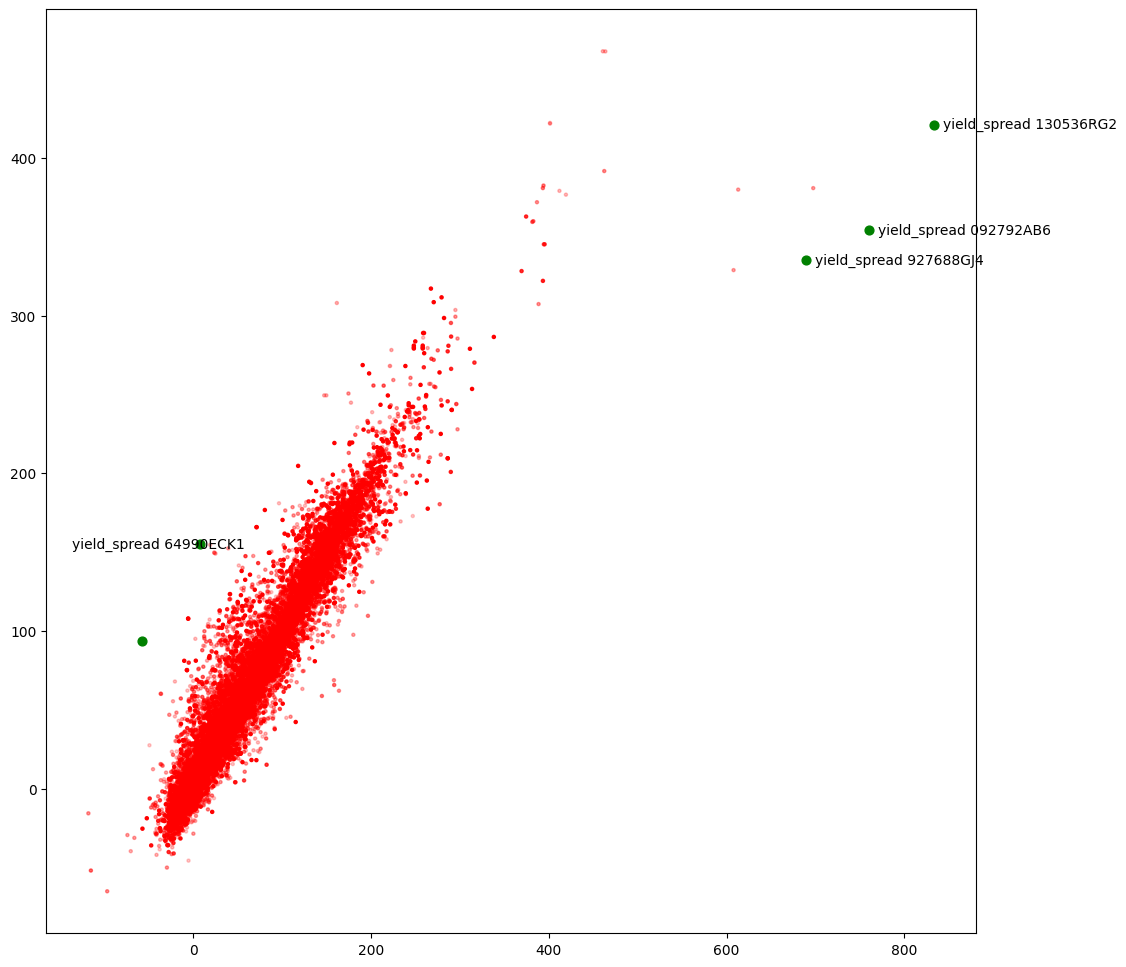

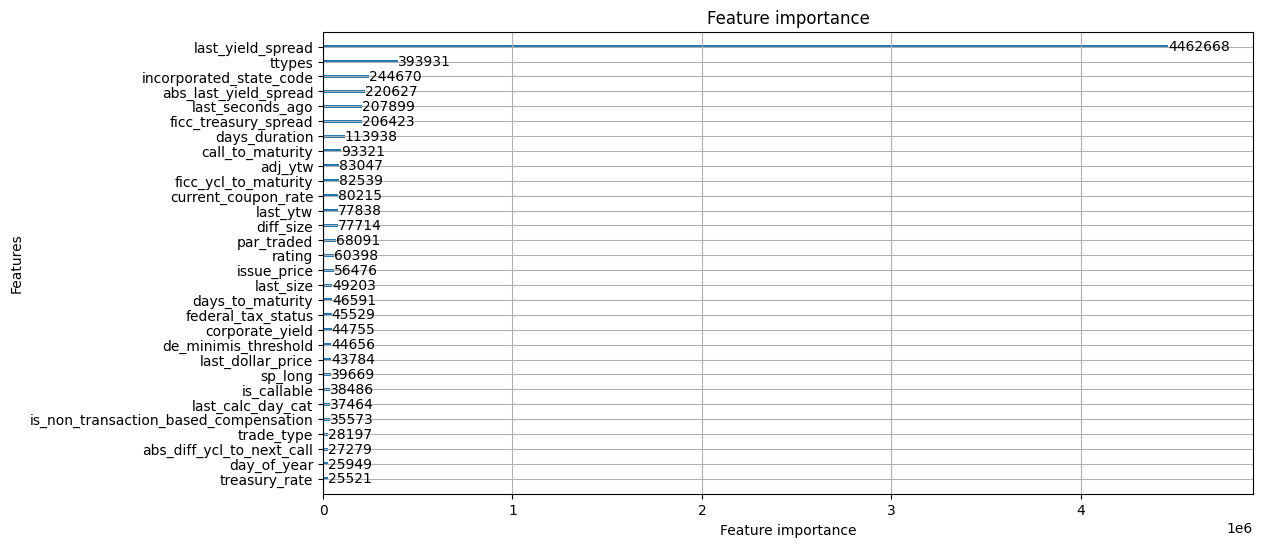

In [91]:
TARGET = 'yield_spread'
extra = []

if TARGET in data.columns:
    ysmodel = myLGBM()
    %time ysmodel.fit( gbmprep(train_dataframe, extra), train_dataframe[TARGET] )

    %time maeval(test_dataframe,  ysmodel, TARGET, extra)
    drawpoints(test_dataframe, TARGET)

    myplotimportance(ysmodel)

#### Predicting yield to worst (YTW)

This target can be predicted with about the same accuracy as unmodified yield spread.
As hypothesized, adjusted last YTW is a better predictor than raw last YTW.

CPU times: user 5min 42s, sys: 14 s, total: 5min 56s
Wall time: 34.6 s

ytw 623369 [] bias -0.34	 MAE  8.43 +/- 12.74 (0.02)	 median  4.85
CPU times: user 59.4 s, sys: 2.04 s, total: 1min 1s
Wall time: 13.9 s

ytw 390976 [] bias -1.63	 MAE 11.16 +/- 14.77 (0.02)	 median  6.96
CPU times: user 35 s, sys: 905 ms, total: 35.9 s
Wall time: 7.74 s

Large ['D'] n=18181	 ytw MAE = 10.05 +/- 13.44 (0.10) median 5.84
092792AB6 08-16  back 169 4.4: S 675 $ 91.30 dur 4869 ys  489  now: D1048 $ 67.00  true 1047.50 pred 655.93 diff  391.57
130536RG2 08-09  back   0 6.4: S1153 $ 69.50 dur 6687 ys  827  now: D1159 $ 69.15  true 1159.40 pred 830.77 diff  328.63
927688GJ4 08-22  back   0 6.0: D 930 $ 94.50 dur  677 ys  698  now: D 922 $ 94.62  true 922.40 pred 610.56 diff  311.84
64990ECK1 08-04  back   1 4.5: P 490 $100.03 dur  132 ys  323  now: D 177 $101.13  true 177.00 pred 392.80 diff -215.80
20786LDT5 10-11  back   0 6.0: D 789 $ 22.60 dur 7020 ys  387  now: D 791 $ 22.52  true 790.90 pred 639.13 

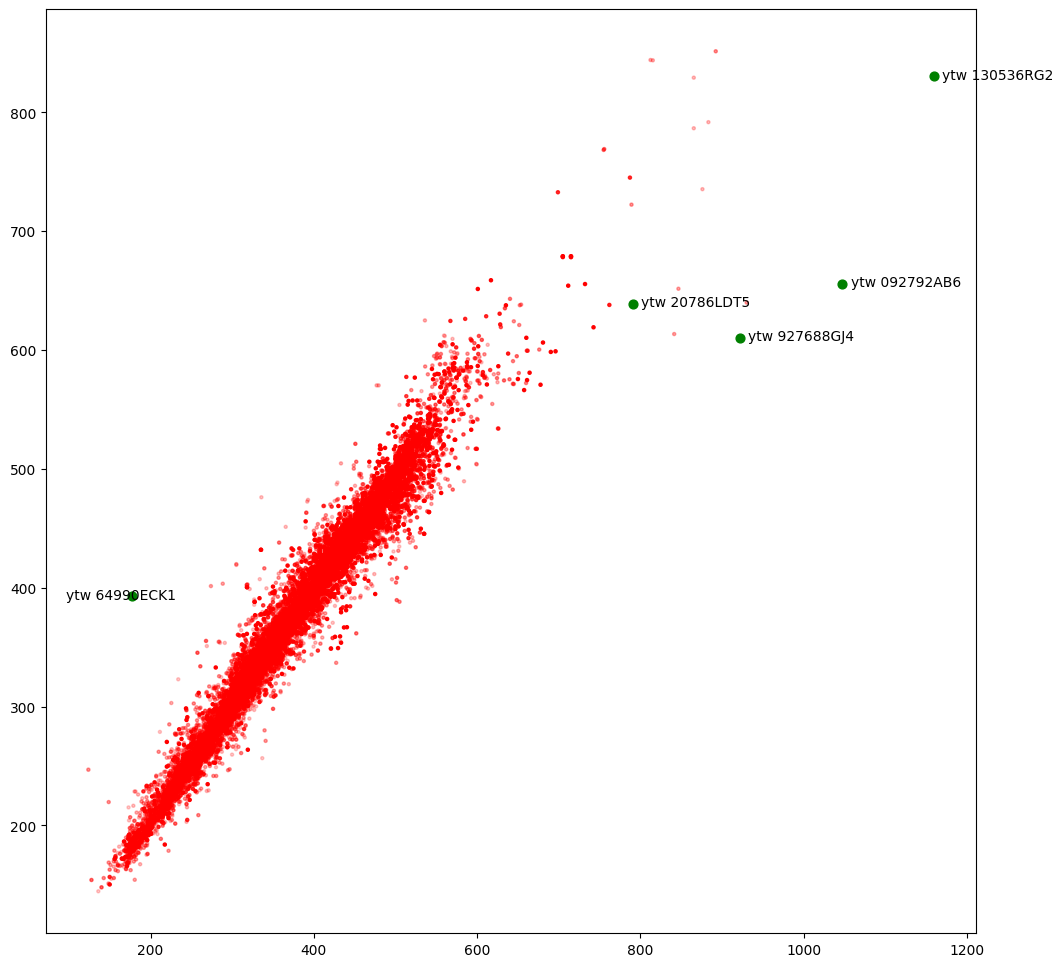

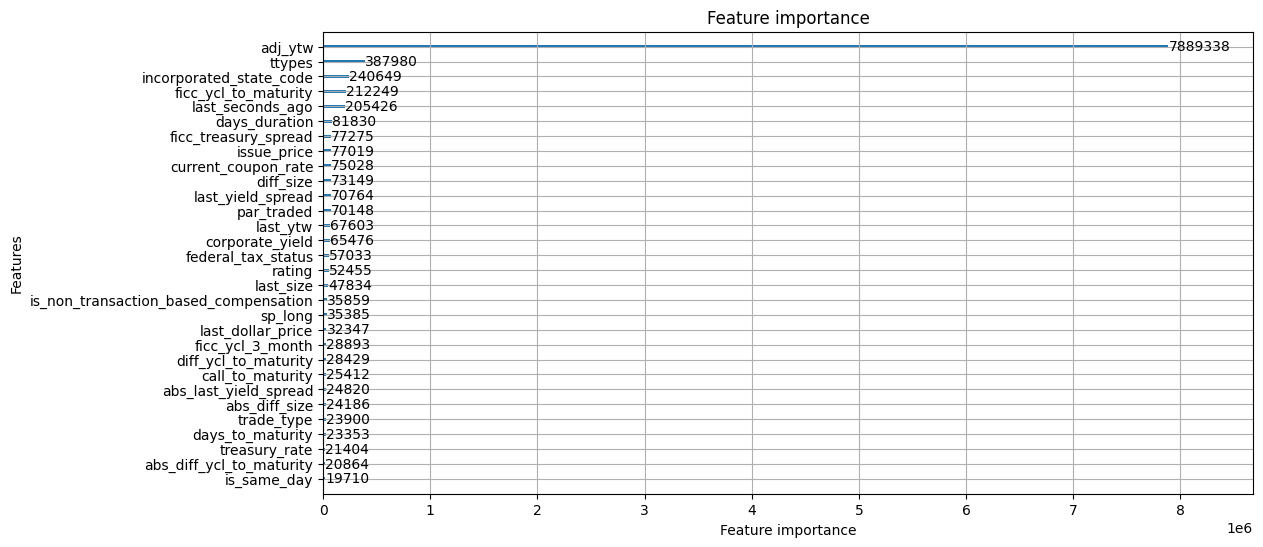

In [92]:
TARGET = 'ytw'
extra = []

ytwmodel = myLGBM()
%time ytwmodel.fit( gbmprep(train_dataframe, extra), train_dataframe[TARGET] )

%time maeval(train_dataframe, ytwmodel, TARGET, extra)
%time maeval(test_dataframe, ytwmodel, TARGET, extra)
drawpoints(test_dataframe, TARGET)

myplotimportance(ytwmodel)

#### Training a model to predict dollar price

Note that errors when predicting dollar price are not directly comparable to those when predicting yields.
Below, we convert errors in dollars to errors in yield, using DV01.

CPU times: user 5min 38s, sys: 14.6 s, total: 5min 52s
Wall time: 34.5 s

dollar_price 623369 [] bias  0.00	 MAE  0.49 +/- 0.71 (0.00)	 median  0.26

dollar_price 390976 [] bias  0.05	 MAE  0.68 +/- 0.90 (0.00)	 median  0.39

Large ['D'] n=18181	 dollar_price MAE = 0.72 +/- 1.06 (0.01) median 0.37
13034AR28 08-30  back   0 6.4: P 734 $  6.30 dur 14002 ys  284  now: D 732 $  6.35  true   6.35 pred  24.71 diff  -18.36
092792AB6 08-16  back 169 4.4: S 675 $ 91.30 dur 4869 ys  489  now: D1048 $ 67.00  true  67.00 pred  85.02 diff  -18.02
952433HS2 09-19  back 826 6.4: S 207 $104.40 dur 3556 ys  136  now: D 332 $ 94.61  true  94.61 pred  79.66 diff   14.95
59447TJ20 09-27  back 125 7.1: S 666 $ 22.12 dur 8406 ys  298  now: D 715 $ 20.34  true  20.34 pred  33.23 diff  -12.89
592041ZW0 10-11  back  25 5.0: S 532 $ 69.02 dur 10877 ys   82  now: D 625 $ 59.46  true  59.46 pred  72.29 diff  -12.82


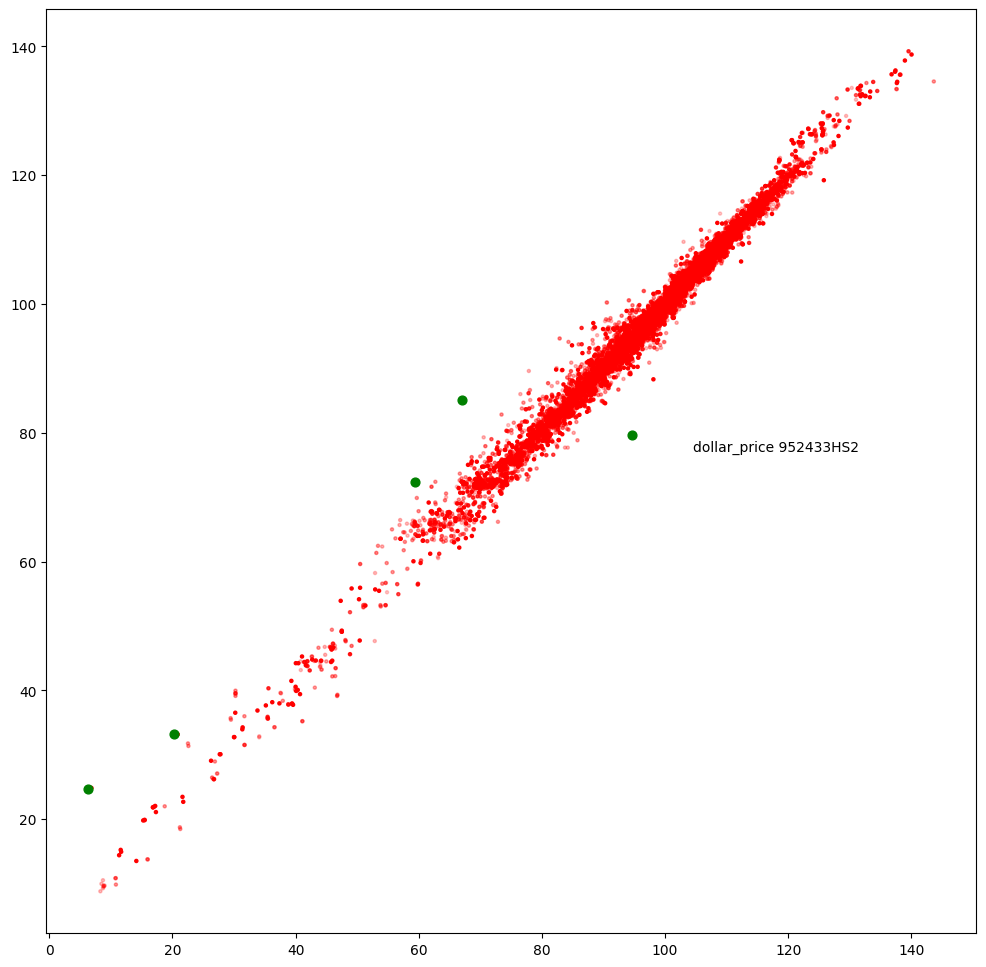

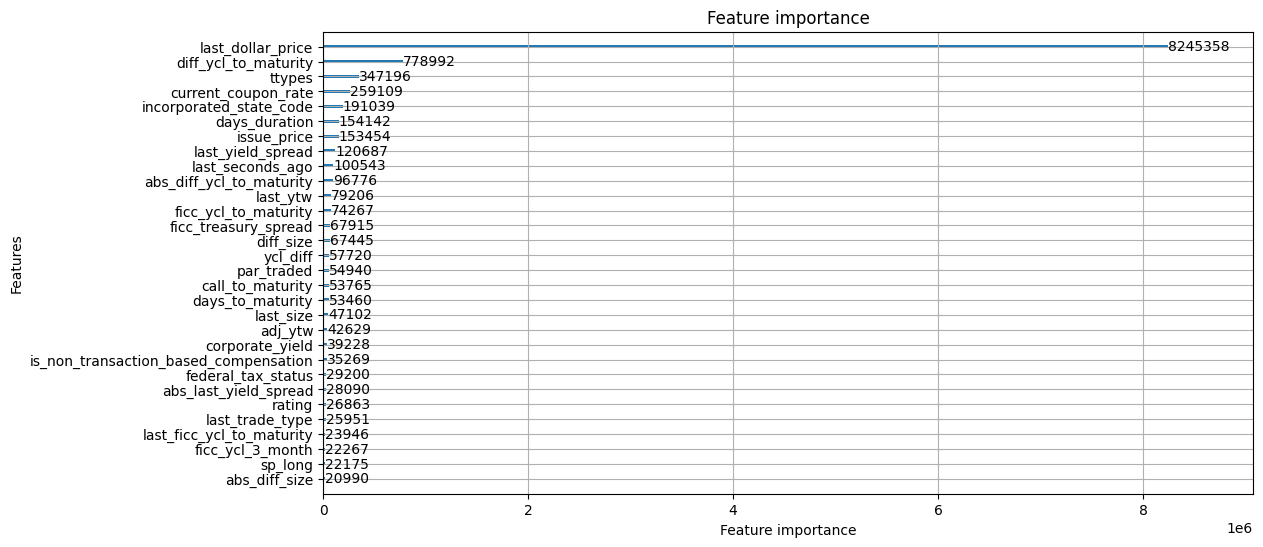

In [93]:
DPTARGET = 'dollar_price'
extra = []

dpmodel = myLGBM()
%time dpmodel.fit( gbmprep(train_dataframe, extra), train_dataframe[DPTARGET] )

maeval(train_dataframe, dpmodel, DPTARGET, extra)
maeval(test_dataframe,  dpmodel, DPTARGET, extra)
drawpoints(test_dataframe, DPTARGET)

myplotimportance(dpmodel)

#### Comparing accuracy for alternative targets

The "compare" function reports the MAE of predictions for alternative targets.
Errors for dollar predictions are converted to basis points
by dividing by DV01, which is more precise than dividing by duration.

Predictions are compared on all trades of \$100,000 or more.
Findings:
- Predicting modified yield spread is almost always the most accurate.
- Predictions are less accurate in basis points for short maturities, 
i.e., for bonds that are less than a year away from redemption.

For how to print text in color, see https://stackoverflow.com/questions/8924173/how-to-print-bold-text-in-python.

In [94]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

For the meaning of categorical values, see https://docs.google.com/spreadsheets/d/172OKmkParOjg9r-N4qWjoTdPxQIZoJ1z/edit#gid=655976637
For example, "use of proceeds = 31" means "Lifecare/retirement centers."

In [95]:
def compare(df, feature, targets, minfrac = 0.0001, maxvals = 30):
    n = len(df)
    vc = df[feature].value_counts()
    header = f"\n{feature:22}        n\t\t"
    for t in targets: header = header + f"{t:>15}  "
        
    vc = vc.sort_index()
    vals = vc.index.to_numpy()
    counts = vc.to_numpy()
    nvals = len(vals)
    printed = 0
    
    for (v,c) in zip( vals, counts ):
        if (c < minfrac * n) and (nvals > 10): continue
        printed = printed+1
        if printed > maxvals: break

        dfv = df[df[feature] == v]
        base = f"{str(v)[0:16]:22} {c:8}\t\t" 
        bestm = 100.0
        
        same_ys_ae = dfv.same_ys_ae
        if same_ys_ae.mean() - 3*same_ys_ae.std()/np.sqrt(c) < 12: continue
        
        if header != "": print(header); header = ""
        
        for t in targets:
            subset = dfv[t]
            mean = subset.mean()
            stderr = subset.std()/np.sqrt(c)
            if mean < bestm + 1 * stderr + 0.01:
                flag = color.PURPLE + color.BOLD
            else:
                flag = color.END + color.CYAN
            if mean < bestm: bestm = mean
            base = base + f"{flag}{mean:>8.2f} ({stderr:4.2f})  "
        print(f"{base}{color.END}")
    return

# from https://quant.stackexchange.com/questions/15549/modified-or-macauley-duration-in-python
def durations(coupon, ytw, years, dollar_price, peryear=2):
    c = (coupon/100) / peryear
    y = (ytw/10000) / peryear
    n = years * peryear
    m = peryear
    macaulay_duration = ((1+y) / (m*y)) - ( (1 + y + n*(c-y)) / ((m*c* ((1+y)**n - 1)) + m*y) )
    modified_duration = macaulay_duration / (1 + y)
    dv01 = modified_duration * dollar_price / 10000
    return macaulay_duration, modified_duration, dv01

def multipliers(df):
    df['yrs_to_calc'] = df.days_to_calc / 365.25
    macaulay_duration, modified_duration, dv01 = durations(df.current_coupon_rate, df.ytw, df.yrs_to_calc, df.dollar_price)
    df['macaulay'] = macaulay_duration
    df['modified'] = modified_duration
    df['dv01'] = dv01
    return df

def adjusterrs(df):
    df = multipliers(df)
    if 'dollar_price_ae' in df.columns: df['dp_ae_adj'] = df.dollar_price_ae / df.dv01
    if 'yield_spread_ae' in df.columns: df['ys_ae_adj'] = df.yield_spread_ae * df.dv01   
    if 'ytw_ae' in df.columns: df['ytw_ae_adj'] = df.ytw_ae * df.dv01
    if 'same_ys_ae' in df.columns: df['sys_ae_adj'] = df.same_ys_ae * df.dv01
    return df

We create the test set with all trades of size 100,000 or more.
We create quantized features to investigate whether accuracy is worse for some of these quantized values.

In [96]:
tmid = test_dataframe[ test_dataframe.quantity >= np.log10(100000) ]
tmid = multipliers(tmid)
tmid = adjusterrs(tmid)

targets = ['yield_spread_ae', 'same_ys_ae', 'ytw_ae', 'dp_ae_adj', 'yrs_to_calc', 'dv01']
    
tmid['fl_last_pricedoll'] = np.floor(tmid.last_dollar_price)
tmid['fl_coupon'] = np.floor(pd.to_numeric(tmid.current_coupon_rate) * 2) / 2 
tmid['fl_log_issue_amount'] = np.floor(pd.to_numeric(tmid.issue_amount)) 
tmid['fl_last_ytw'] = np.floor(tmid.last_ytw/25) / 4

We investigate eliminating certain trades from the test set.
All the eliminations below in fact remove no trades,
because the same exclusion criteria were applied above before training.

In [97]:
cols = sorted(tmid.select_dtypes(exclude=['object']).columns, key=str.casefold)
for c in cols: 
    if c.endswith("_date"): continue
    compare(tmid, c, targets, 0.003)


abs_diff_size                 n		yield_spread_ae       same_ys_ae           ytw_ae        dp_ae_adj      yrs_to_calc             dv01  
0.45591954741321           1668		   12.91 (0.33)     13.08 (0.33)     12.42 (0.33)     14.67 (0.45)      8.75 (0.18)      0.07 (0.00)  
0.60204261989611           9865		   13.65 (0.16)     13.30 (0.16)     12.23 (0.15)     15.62 (0.34)      9.98 (0.08)      0.07 (0.00)  
0.69894829015477           4777		   13.92 (0.26)     13.59 (0.25)     12.79 (0.24)     15.42 (0.44)      9.56 (0.11)      0.07 (0.00)  
0.69895261974352           1272		   12.92 (0.37)     13.29 (0.38)     12.09 (0.35)     19.46 (1.82)      7.98 (0.20)      0.06 (0.00)  
0.77813381404894           1813		   13.53 (0.38)     13.30 (0.40)     12.34 (0.35)     15.99 (0.61)      9.36 (0.20)      0.07 (0.00)  

abs_t_rate_diff_1             n		yield_spread_ae       same_ys_ae           ytw_ae        dp_ae_adj      yrs_to_calc             dv01  
1.00000000000002          16646		   13.29 (0.1

#### Learning to predict the absolute error of predictions 

In principle, training this model on the same training dataframe causes overfitting.
In practice, training on one test dataframe gives a negligible improvement on the other test dataframe.
Re-using the same training dataframe allows the gap in time to be smaller between training and test data.

In [98]:
TARGET = "same_ys"
TARGET_AE = TARGET + "_ae"
extra = []

aemodel = myLGBM()
%time aemodel.fit( gbmprep(train_dataframe, extra), train_dataframe[TARGET_AE] )

maeval(train_dataframe, aemodel, TARGET_AE, extra)
maeval(test_dataframe, aemodel, TARGET_AE, extra)

myplotimportance(aemodel)

KeyError: "['month'] not in index"

KeyError: "['month'] not in index"

#### Declining to predict when the expected absolute error is large

Declining to predict on 10\% of test examples reduces large dealer-dealer MAE in September by about 1.5 basis points,
and eliminates all errors larger than 100 basis points.
Note that the 90th percentile of predicted errors for large DD trades is much smaller than for all trades.

In [ ]:
test_dataframe[TARGET_AE + '_preds'].mean() # quantile(0.9)

5.759710678270215

: 

: 


Large ['D'] n=3803	 same_ys MAE = 7.90 +/- 8.77 (0.14) median 4.95
592041ZW0 10-11  back  25 5.0: S 532 $ 69.02 dur 10877 ys   82  now: D 625 $ 59.46  true 180.17 pred 101.19 diff   78.98
663903KT8 10-03  back   4 5.7: P 507 $ 89.52 dur 2600 ys  156  now: D 429 $ 93.98  true  82.44 pred 153.56 diff  -71.12
733911CN9 10-11  back  25 5.0: D 521 $ 96.35 dur 5916 ys  142  now: D 600 $ 88.50  true 215.30 pred 145.09 diff   70.22
574296CD9 10-12  back  13 6.2: D 478 $ 87.70 dur 1671 ys  147  now: D 404 $ 90.62  true  88.06 pred 154.10 diff  -66.03
115117MP5 10-13  back 324 5.7: S 220 $108.16 dur 2866 ys  134  now: D 566 $ 76.74  true 230.76 pred 168.93 diff   61.83

Large ['D'] n=4198	 same_ys MAE = 9.35 +/- 11.65 (0.18) median 5.50
017569AA2 10-03  back 444 4.7: P 493 $ 99.04 dur 2234 ys  447  now: D 477 $ 99.91  true 147.43 pred 283.74 diff -136.30
052476ZQ4 10-06  back   3 4.7: S 252 $100.27 dur   41 ys  -92  now: D 280 $100.20  true -57.37 pred  69.13 diff -126.50
89602NZL1 10-12  back 

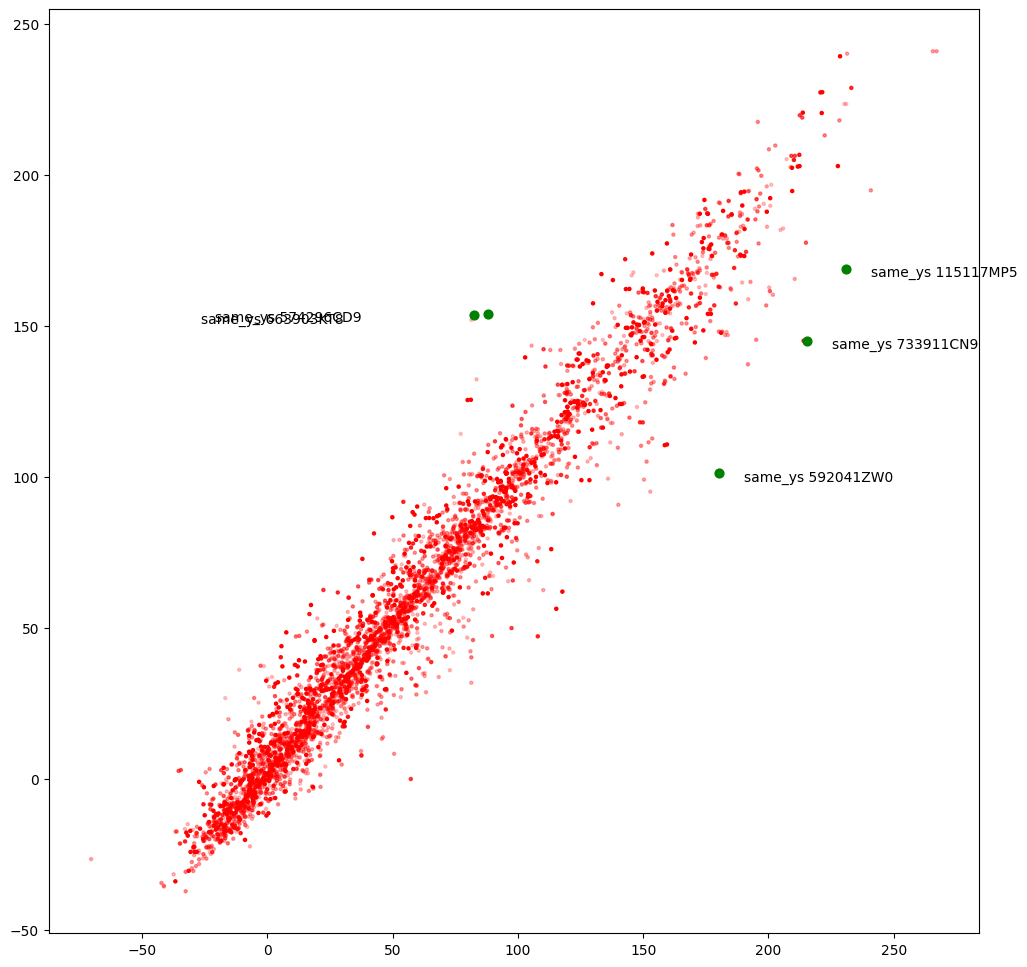

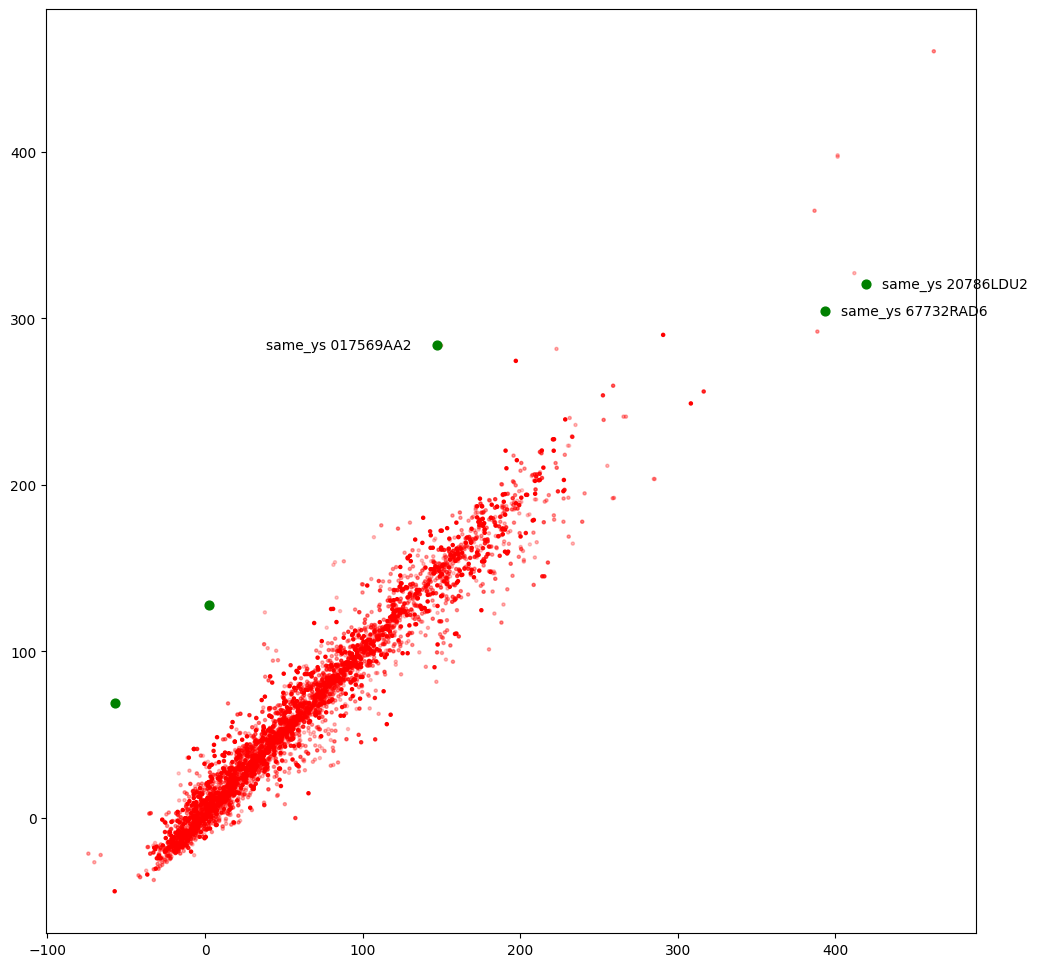

: 

: 

In [ ]:
TARGET = "same_ys"
inclusion = test_dataframe[TARGET_AE + '_preds'] < 9.55

drawpoints(test_dataframe[inclusion], TARGET)
drawpoints(test_dataframe, TARGET)

Below is a quick evaluation of our pricing module.

In [109]:

'''
 # @ Create Time: 2022-01-13 23:04:00
 # @ Modified by: Developer
 # @ Modified time: 2022-02-25 14:04:00
 # @ Description: This file implements functions to compute the price of a trade
 # given the yield.
 '''
import numpy as np
import pandas as pd

from ficc.utils.auxiliary_variables import NUM_OF_DAYS_IN_YEAR
from ficc.utils.auxiliary_functions import compare_dates
from ficc.utils.diff_in_days import diff_in_days_two_dates
from ficc.utils.frequency import get_time_delta_from_interest_frequency
from ficc.utils.truncation import trunc_and_round_price
from ficc.pricing.auxiliary_functions import get_num_of_interest_payments_and_final_coupon_date, \
                                             price_of_bond_with_multiple_periodic_interest_payments, \
                                             get_prev_coupon_date_and_next_coupon_date, \
                                             price_of_bond_with_interest_at_maturity
from ficc.pricing.called_trade import end_date_for_called_bond, refund_price_for_called_bond

'''
This function is a helper function for `compute_price`. This function calculates the price of a trade, where `yield_rate` 
is a specific yield and `end_date` is a fixed repayment date. All dates must be valid relative to the settlement 
date, as opposed to the trade date. Note that "yield" is a reserved word in Python and should not be used as the name 
of a variable or column.

Formulas are from https://www.msrb.org/pdf.aspx?url=https%3A%2F%2Fwww.msrb.org%2FRules-and-Interpretations%2FMSRB-Rules%2FGeneral%2FRule-G-33.aspx.
For all bonds, `base` is the present value of future cashflows to the buyer. 
The clean price is this price minus the accumulated amount of simple interest that the buyer must pay to the seller, which is called `accrued`.
Zero-coupon bonds are handled first. For these, the yield is assumed to be compounded semi-annually, i.e., once every six months.
For bonds with non-zero coupon, the first and last interest payment periods may have a non-standard length,
so they must be handled separately.

When referring to the formulas in the MSRB handbook (link above), the below variables map to the code.
A: prev_coupon_date_to_settlement_date
B: NUM_OF_DAYS_IN_YEAR
Y: yield_rate
N: num_of_interest_payments
E: num_of_days_in_period
F: settlement_date_to_next_coupon_date
P: price
D: settlement_date_to_end_date
H: prev_coupon_date_to_end_date
R: coupon
'''
def get_price(cusip, 
              prev_coupon_date, 
              first_coupon_date, 
              next_coupon_date, 
              end_date, 
              settlement_date, 
              accrual_date, 
              frequency, 
              yield_rate, 
              coupon, 
              RV, 
              time_delta, 
              last_period_accrues_from_date):
    yield_rate = yield_rate / 100

    
    # Right now we do not disambiguate zero coupon from interest at maturity. More specfically, 
    # we should add logic that separates the cases of MSRB Rule Book G-33, rule (b) and rule (c)
    if frequency == 0:
        # See description for `price_of_bond_with_interest_at_maturity`
        price = price_of_bond_with_interest_at_maturity(cusip, 
                                                        settlement_date, 
                                                        accrual_date, 
                                                        end_date, 
                                                        yield_rate, 
                                                        coupon, 
                                                        RV)
    else:
        num_of_interest_payments, final_coupon_date = get_num_of_interest_payments_and_final_coupon_date(next_coupon_date, 
                                                                                                         end_date, 
                                                                                                         time_delta)
        prev_coupon_date_to_settlement_date = diff_in_days_two_dates(settlement_date, prev_coupon_date)
            
        num_of_days_in_period = NUM_OF_DAYS_IN_YEAR / frequency    # number of days in interest payment period 
        assert num_of_days_in_period == round(num_of_days_in_period)
         
        if compare_dates(end_date, next_coupon_date) <= 0:
            # MSRB Rule Book G-33, rule (b)(i)(B)(1)
            settlement_date_to_end_date = diff_in_days_two_dates(end_date, settlement_date)
            final_coupon_date_to_end_date = diff_in_days_two_dates(end_date, final_coupon_date)
            interest_due_at_end_date = coupon * final_coupon_date_to_end_date / NUM_OF_DAYS_IN_YEAR
            base = (RV + coupon / frequency + interest_due_at_end_date) / \
                   (1 + (yield_rate / frequency) * settlement_date_to_end_date / num_of_days_in_period)
            accrued = coupon * prev_coupon_date_to_settlement_date / NUM_OF_DAYS_IN_YEAR
            price = base - accrued
        else:
            # MSRB Rule Book G-33, rule (b)(i)(B)(2)
            price = price_of_bond_with_multiple_periodic_interest_payments(cusip, 
                                                                           settlement_date, 
                                                                           accrual_date, 
                                                                           first_coupon_date, 
                                                                           prev_coupon_date, 
                                                                           next_coupon_date, 
                                                                           final_coupon_date, 
                                                                           end_date,  
                                                                           frequency,
                                                                           num_of_interest_payments, 
                                                                           yield_rate,
                                                                           coupon, 
                                                                           RV, 
                                                                           time_delta, 
                                                                           last_period_accrues_from_date)              
    return trunc_and_round_price(price)

'''
This function computes the price of a trade. For bonds that have not been called, the price is the lowest of
three present values: to the next call date (which may be above par), to the next par call date, and to maturity.
'''
def compute_price(trade, yield_rate=None):
    if yield_rate == None:
        yield_rate = trade.ficc_ytw
    elif type(yield_rate) == str:
        raise ValueError('Yield rate argument cannot be a string. It must be a numerical value.')

    frequency = trade.interest_payment_frequency
    time_delta = get_time_delta_from_interest_frequency(frequency)
    my_prev_coupon_date, my_next_coupon_date = get_prev_coupon_date_and_next_coupon_date(trade, frequency, time_delta)

    get_price_caller = lambda end_date, redemption_value: get_price(trade.cusip, 
                                                                    my_prev_coupon_date, 
                                                                    trade.first_coupon_date, 
                                                                    my_next_coupon_date, 
                                                                    end_date, 
                                                                    trade.settlement_date, 
                                                                    trade.accrual_date, 
                                                                    frequency, 
                                                                    yield_rate, 
                                                                    trade.coupon, 
                                                                    redemption_value, 
                                                                    time_delta, 
                                                                    trade.last_period_accrues_from_date)

    redemption_value_at_maturity = 100
    if (not trade.is_called) and (not trade.is_callable):
        yield_to_maturity = get_price_caller(trade.maturity_date, redemption_value_at_maturity)
        return yield_to_maturity, trade.maturity_date
    elif trade.is_called:
        end_date = end_date_for_called_bond(trade)

        if compare_dates(end_date, trade.settlement_date) < 0:
            print(f"Bond (CUSIP: {trade.cusip}, RTRS: {trade.rtrs_control_number}) has an end date ({end_date}) which is after the settlement date ({trade.settlement_date}).")    # printing instead of raising an error to not disrupt processing large quantities of trades
            # raise ValueError(f"Bond (CUSIP: {trade.cusip}, RTRS: {trade.rtrs_control_number}) has an end date ({end_date}) which is after the settlement date ({trade.settlement_date}).")
        
        redemption_value_at_refund = refund_price_for_called_bond(trade)
        return get_price_caller(end_date, redemption_value_at_refund), end_date
    else:
        next_price, to_par_price, maturity_price = float('inf'), float('inf'), float('inf')

        if not pd.isnull(trade.par_call_date):
            to_par_price = get_price_caller(trade.par_call_date, trade.par_call_price)
        if not pd.isnull(trade.next_call_date):
            next_price = get_price_caller(trade.next_call_date, trade.next_call_price)
        maturity_price = get_price_caller(trade.maturity_date, redemption_value_at_maturity)

        prices_and_dates = [(next_price, trade.next_call_date), 
                            (to_par_price, trade.par_call_date), 
                            (maturity_price, trade.maturity_date)]
        calc_price, calc_date = min(prices_and_dates, key=lambda pair: pair[0])    # this function is stable and will choose the pair which appears first in the case of ties for the lowest price
    return calc_price, calc_date


In [112]:
temp = data[data.cusip == '160429B88']
from ficc.utils.auxiliary_variables import COUPON_FREQUENCY_TYPE

#temp['ficc_ytw'] = 4.201

#temp.interest_payment_frequency

temp.loc[:,'interest_payment_frequency'] = temp.interest_payment_frequency.apply(lambda x: COUPON_FREQUENCY_TYPE[x])
compute_price(temp.iloc[0],4.289)


/var/folders/4p/6gk1pj4j1439gxdnw_vb8prw0000gn/T/ipykernel_1716/3123366740.py:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  temp.loc[:,'interest_payment_frequency'] = temp.interest_payment_frequency.apply(lambda x: COUPON_FREQUENCY_TYPE[x])


(105.704, Timestamp('2032-07-01 00:00:00'))

In [ ]:

temp['ficc_price'],_ = zip(*temp.progress_apply(lambda x: compute_price(x),axis=1))

1it [00:00, 745.65it/s]


ValueError: too many values to unpack (expected 2)

: 

: 

<AxesSubplot: xlabel='dollar_price', ylabel='ficc_price'>

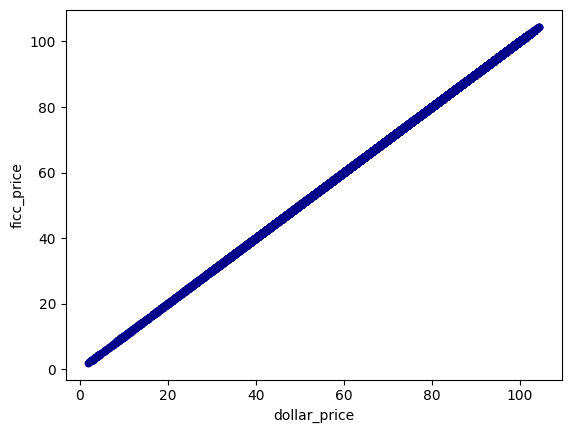

: 

: 

In [ ]:
import matplotlib.pyplot as plt
temp.plot.scatter(x='dollar_price', y='ficc_price', c='DarkBlue')

In [ ]:
temp['delta_price'] = temp.ficc_price - temp.dollar_price

: 

: 

In [ ]:
print( "MSE =", ((temp.ficc_price - temp.dollar_price)**2).mean() )

NameError: name 'temp' is not defined

In [ ]:
temp[temp.delta_price != 0]

,MSRB_maturity_date,MSRB_coupon_rate,msrb_cusip,yield_spread,calc_price,price_to_next_call,price_to_par_call,price_to_maturity,calc_date,price_delta,...,last_ficc_ycl_to_refund,is_replica,is_bookkeeping,is_same_day,ntbc_precursor,corporate_yield,corporate_spread,ficc_ytw,ficc_price,delta_price
38,2031-04-01,5.000000000,13063DLJ5,-31.765,113.530,0.000,0.000,0.000,2031-04-01,4.000e-03,...,NaN,False,False,True,False,5.11,-162.935,3.163,113.530,-4.000e-03
96,2031-04-01,5.000000000,13063DLJ5,-25.465,113.031,0.000,0.000,0.000,2031-04-01,3.000e-03,...,NaN,False,False,True,False,5.11,-162.935,3.226,113.031,-3.000e-03
112,2045-05-01,4.000000000,64971XQM3,14.205,91.451,95.914,95.914,91.451,2045-05-01,4.000e-03,...,NaN,False,False,True,False,5.25,-77.805,4.614,91.451,4.000e-03
5269,2031-04-01,5.000000000,13063DLJ5,-36.365,113.896,0.000,0.000,0.000,2031-04-01,3.000e-03,...,NaN,False,False,True,False,5.11,-162.935,3.117,113.896,-3.000e-03
6951,2045-06-15,4.000000000,6461367J4,40.312,87.997,94.123,94.123,87.997,2045-06-15,3.000e-03,...,NaN,False,False,True,False,5.25,-77.212,4.881,87.997,-3.000e-03
6973,2045-06-15,4.000000000,6461367J4,40.312,87.997,94.123,94.123,87.997,2045-06-15,3.000e-03,...,NaN,False,False,True,False,5.25,-77.212,4.881,87.997,-3.000e-03
8813,2045-06-15,4.000000000,6461367J4,59.512,85.641,92.898,92.898,85.641,2045-06-15,4.000e-03,...,NaN,False,False,True,False,5.25,-77.212,5.073,85.641,-4.000e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5201278,2031-04-01,5.000000000,13063DLJ5,-14.014,122.884,0.000,0.000,0.000,2031-04-01,1.000e-03,...,NaN,False,False,False,False,3.47,-114.886,2.181,122.884,-1.000e-03
5252249,2031-04-01,5.000000000,13063DLJ5,0.661,121.806,0.000,0.000,0.000,2031-04-01,4.000e-03,...,NaN,False,False,False,False,3.47,-117.661,2.300,121.806,-4.000e-03


: 

: 

: 

: 